# 문제 정의

- 데이터 사이언스에서 널리 사용하는 문제 해결 도구가 머신러닝
- 퇴근시간 버스 승차인원 예측 경진대회에 대한 소개와 평가척도, 그리고 문제 해결을 위한 접근 방식 소개

## 경진대회 소개

- 공공 교통 위치 빅데이터를 이용해 버스 승객 이용을 분석하는 대회임
- 제주테크노파크에서 효율적인 버스 운행을 통해 교통난 심화를 해결하기 위해 퇴근시간 버스 승차인원 예측 경진대회를 개최
- 외국인과 관광객까지 고려하면 전체 상주인구는 90만 명을 넘을 것으로 추정됨
- 제주 일부 지역은 교통 체증이 심각함
- 교통 체증 문제를 해결하는 것이 목적

## 평가척도

- 학습 라벨이 존재하므로 지도학습 범주에 속함
- 지도학습의 종류
    - 분류, 회귀
         - 예측하고자 하는 변수가 범주형이면 분류
         - 실수형이면 회귀 

---
- RMSE(Root Mean Square Error, 제곱근평균제곱오차)
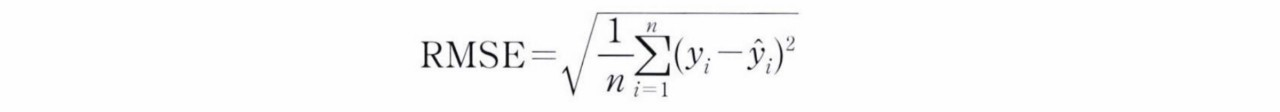
- 실제 값(yi)과 예측값(y^i) 차이의 제곱 합을 데이터의 전체 수로 나눈 뒤, 제곱근을 구함
- 좋은 모델일 수록 RMSE가 낮음

## 문제 해결을 위한 접근 방식 소개

- 두 가지 유념
    - 오전 시간에 해당하는 데이터만 활용해서 퇴근 시간(18:00 ~ 20:00)의 버스 승차 인원을 예측해야 한다는 것
        - 오후 시간의 데이터를 학습에 사용하면 데이터 누수(data leakage)에 해당해 실격 처리될 수 있음
        - 데이터 누수 : 모델을 학습시킬 때 범주 밖의 데이터, 활용할 수 없는 데이터를 말함
    - 9월 1일부터 30일까지 한 달간의 데이터만 활용해서 10월 1~15일의 퇴근시간 승차인원을 예측해야 한다는 점
        - 이외의 데이터를 학습에 사용시 실격
        

## 분석환경 구축

**데이콘 데이터 내려받기**

# 탐색적 데이터 분석

- **데이터 경로 설정**
- 데이터가 있는 위치를 알려줘야 함

In [2]:
# # 작업 경로 설정
# import os
# os.chdir(r'./')

## 데이터 설명

In [3]:
import pandas as pd
# 데이터 로드
train = pd.read_csv('./229255_bus_riders_at_rush_hour_data/train.csv')
test = pd.read_csv('./229255_bus_riders_at_rush_hour_data/test.csv')
bts = pd.read_csv('./229255_bus_riders_at_rush_hour_data/bus_bts.csv')
jeju_life = pd.read_csv('./82407_KCB_financial_style_data/jeju_financial_life_data.csv')
weather = pd.read_csv('./229255_bus_riders_at_rush_hour_data/ch03/weather.csv',encoding='cp949')
rain = pd.read_csv('./229255_bus_riders_at_rush_hour_data/ch03/rain.csv', encoding='utf-8')

- **train.csv와 test.csv**
- 6시~ 12시의 버스 정류장별 승하차 인원과 퇴근 시간(18~20시)의 버스 정류장별 승차 인원이 기록됨

In [4]:
# 학습 데이터 상위 5줄 출력
train.head()

id        date  bus_route_id in_out  station_code  station_name  latitude  \
0   0  2019-09-01       4270000     시외           344         제주썬호텔  33.48990   
1   1  2019-09-01       4270000     시외           357          한라병원  33.48944   
2   2  2019-09-01       4270000     시외           432          정존마을  33.48181   
3   3  2019-09-01       4270000     시내          1579  제주국제공항(600번)  33.50577   
4   4  2019-09-01       4270000     시내          1646      중문관광단지입구  33.25579   

   longitude  6~7_ride  7~8_ride  ...  9~10_ride  10~11_ride  11~12_ride  \
0  126.49373       0.0       1.0  ...        5.0         2.0         6.0   
1  126.48508       1.0       4.0  ...        2.0         5.0         6.0   
2  126.47352       1.0       1.0  ...        2.0         0.0         0.0   
3  126.49252       0.0      17.0  ...       26.0        14.0        16.0   
4  126.41260       0.0       0.0  ...        0.0         0.0         0.0   

   6~7_takeoff  7~8_takeoff  8~9_takeoff  9~10_takeoff  10~11_takeoff  \
0          0.0          0.0          0.0           0.0            0.0   
1          0.0          0.0          0.0           0.0            0.0   
2          0.0          0.0          0.0           0.0            0.0   
3          0.0          0.0          0.0           0.0            0.0   
4          0.0          0.0          0.0           1.0            0.0   

   11~12_takeoff  18~20_ride  
0            0.0         0.0  
1            0.0         5.0  
2            0.0         2.0  
3            0.0        53.0  
4            0.0         0.0  

[5 rows x 21 columns]

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 415423 entries, 0 to 415422
Data columns (total 21 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   id             415423 non-null  int64  
 1   date           415423 non-null  object 
 2   bus_route_id   415423 non-null  int64  
 3   in_out         415423 non-null  object 
 4   station_code   415423 non-null  int64  
 5   station_name   415423 non-null  object 
 6   latitude       415423 non-null  float64
 7   longitude      415423 non-null  float64
 8   6~7_ride       415423 non-null  float64
 9   7~8_ride       415423 non-null  float64
 10  8~9_ride       415423 non-null  float64
 11  9~10_ride      415423 non-null  float64
 12  10~11_ride     415423 non-null  float64
 13  11~12_ride     415423 non-null  float64
 14  6~7_takeoff    415423 non-null  float64
 15  7~8_takeoff    415423 non-null  float64
 16  8~9_takeoff    415423 non-null  float64
 17  9~10_takeoff   415423 non-nul

- 415,423개의 행에 대해 Non-Null이 415,423개로 결측치 존재하지 않음

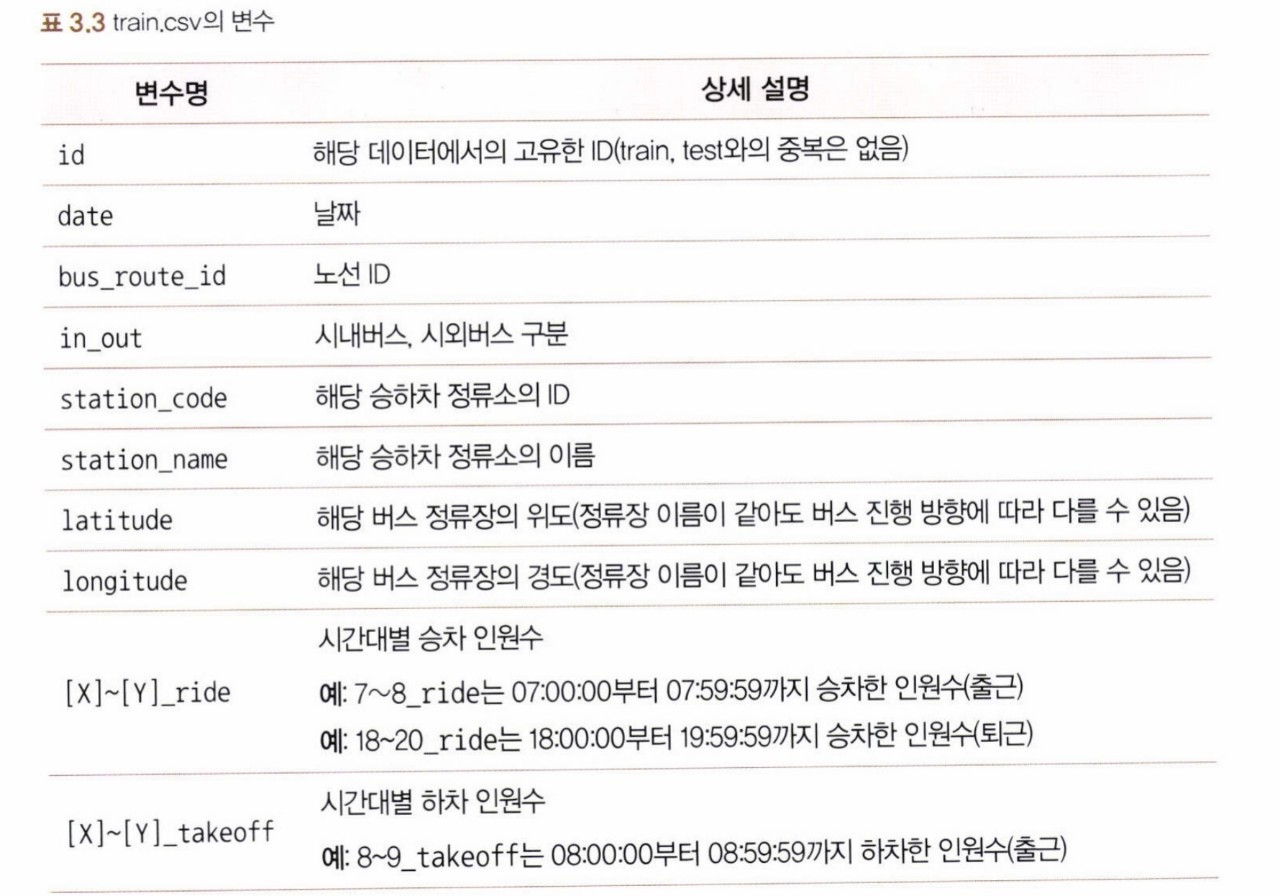

- **bus_bts.csv**
- 버스 카드별 승하차 정보가 기록되어 있음
- geton_time 변수를 기준으로 탑승 시간대가 오전 6시부터 12시 사이인 것만 존재함
- 학습 데이터와 테스트 데이터의 X~Y_ride 변수의 합과 bus_bts 데이터의 user_count 변수의 합은 서로 같음
- 즉, 학습 데이터와 테스트 데이터에서 시간마다 탑승한 승객의 정보를 but_bts 데이터를 통해 알 수 있음
- bus_route_id 변수를 기준으로 학습 데이터와 병합(merge)하여 다양한 방면으로 분석할 수 있음

In [6]:
bts.head()

user_card_id  bus_route_id     vhc_id  geton_date geton_time  \
0  1.010010e+15      23000000  149793674  2019-09-10   06:34:45   
1  1.010010e+15      23000000  149793674  2019-09-10   06:34:58   
2  1.019160e+15      21420000  149793535  2019-09-10   07:19:07   
3  1.019150e+15      21420000  149793512  2019-09-09   09:14:47   
4  1.010010e+15      21420000  149793512  2019-09-09   09:28:53   

   geton_station_code geton_station_name getoff_date getoff_time  \
0                 360              노형오거리  2019-09-10    07:10:31   
1                 360              노형오거리  2019-09-10    06:56:27   
2                2495     동광환승정류장4(제주방면)  2019-09-10    07:40:29   
3                3282    대정환승정류장(대정읍사무소)  2019-09-09    10:02:46   
4                2820              삼정지에듀  2019-09-09    10:21:37   

   getoff_station_code getoff_station_name  user_category  user_count  
0                592.0              화북초등학교              1           1  
1               3273.0          고산동산(광양방면)              1           1  
2                431.0                정존마을              4           1  
3                431.0                정존마을              1           1  
4               2972.0          제주국제공항(종점)              4           1

In [7]:
# bus_bts 데이터 정보 출력
bts.info(null_counts=True)

C:\Users\hansol\AppData\Local\Temp/ipykernel_6760/2621550824.py:2: FutureWarning: null_counts is deprecated. Use show_counts instead
  bts.info(null_counts=True)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2409414 entries, 0 to 2409413
Data columns (total 13 columns):
 #   Column               Non-Null Count    Dtype  
---  ------               --------------    -----  
 0   user_card_id         2409414 non-null  float64
 1   bus_route_id         2409414 non-null  int64  
 2   vhc_id               2409414 non-null  int64  
 3   geton_date           2409414 non-null  object 
 4   geton_time           2409414 non-null  object 
 5   geton_station_code   2409414 non-null  int64  
 6   geton_station_name   2409365 non-null  object 
 7   getoff_date          1513678 non-null  object 
 8   getoff_time          1513678 non-null  object 
 9   getoff_station_code  1513678 non-null  float64
 10  getoff_station_name  1513639 non-null  object 
 11  user_category        2409414 non-null  int64  
 12  user_count           2409414 non-null  int64  
dtypes: float64(2), int64(5), object(6)
memory usage: 239.0+ MB


- 확인 결과 
- geton_station_name 변수에 49개
- getoff_date, getoff_time, getoff_station_code 변수에 895,736개
- getoff_station_name 변수에 895,775개의 결측치 존재함
- getoff와 관련된 변수의 결측치는 승객이 하차 태그를 하지 않으면 발생함
---
- info() 명령어를 사용하면 결측치의 존재 여부를 확인할 수는 있지만, 설정된 최대 행, 열 표시 개수보다 작을 때만 표시됨
- 설정된 최대 변수의 수는 pd.options.display.max_info_columns
- 최대 행의 수는 pd.options.display.max_info_rows로 확인할 수 있음
- null_counts=True로 설정하면 변수별 Non-Null의 수를 알 수 있음

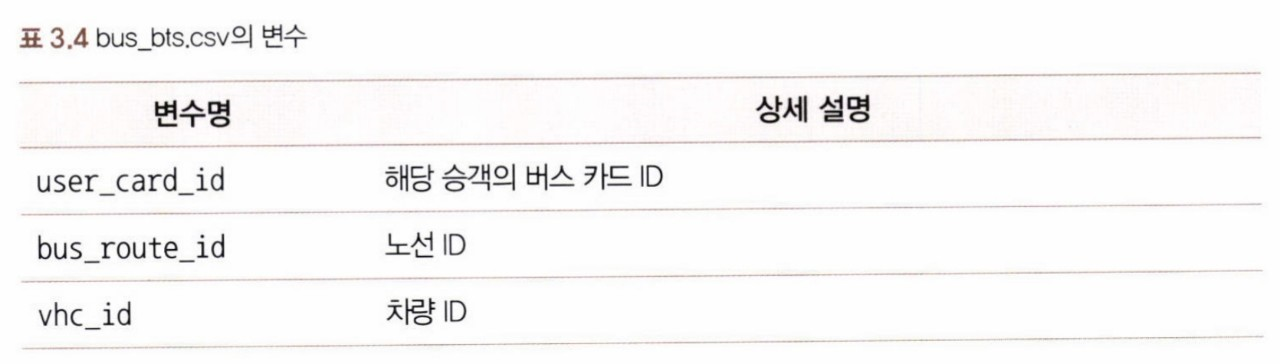

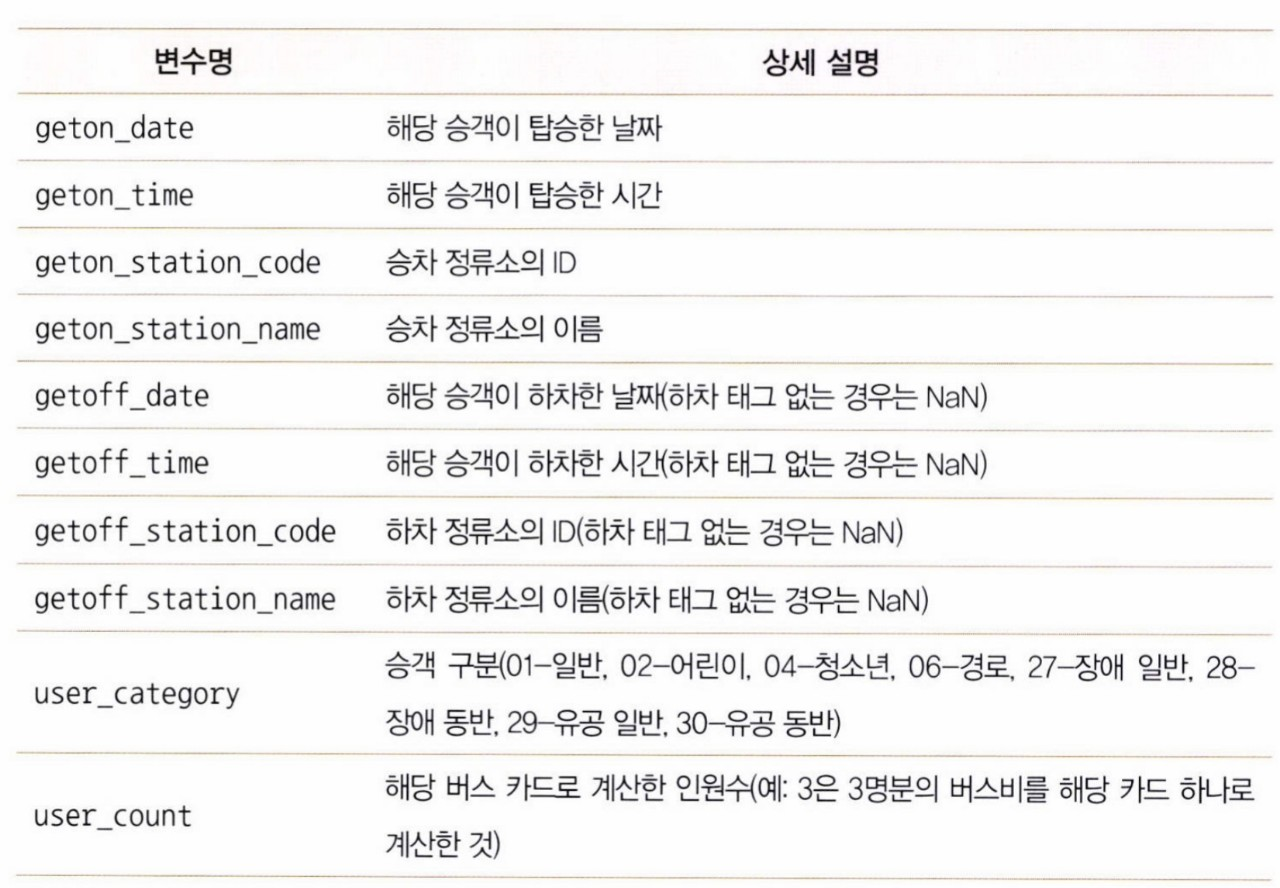

- **jeju_financial_life_data.csv**


- 'KCB 금융스타일 시각화 경진대회'에서 사용한 데이터
- 기본으로 주어진 데이터 외에 추가로 내려받아 사용할 수 있음
- 제주도의 우편번호를 단위로 구분한 제주도 지역민의 금융 생활에 대한 통계 자료
- x_axis, y_axis 변수 데이터와 테스트 데이터의 latitude, longitude 변수를 기준으로 두 데이터를 병합해 분석할 수도 있음
- 두 데이터를 병합하려면 전처리 과정이 필요함

In [8]:
# jeju_financial_life_data 데이터 상위 5줄 출력
jeju_life.head()

zip_cd  year_month      x_axis     y_axis  sex  age  job_majorc  \
0   63299      201902  126.565889  33.513210    1   54         0.0   
1   63560      201902  126.497121  33.247225    1   59         0.0   
2   63560      201902  126.497121  33.247225    2   49         0.0   
3   63560      201902  126.497121  33.247225    1   54         0.0   
4   63560      201902  126.497121  33.247225    1   49         0.0   

   job_smallc  job_public  job_profession  ...   avg_debt  avg_debt_credit  \
0    0.166667    0.000000        0.000000  ...   24285196         11419148   
1    0.125000    0.000000        0.000000  ...  108571077         25896955   
2    0.250000    0.000000        0.000000  ...   26424335         12015311   
3    0.181818    0.090909        0.090909  ...  647716901         39952556   
4    0.250000    0.000000        0.000000  ...  248232725         35712501   

   avg_debt_noneb  avg_debt_mortgage  avg_debt_deposit  avg_debt_collateral  \
0         8863595           55550000                 0             55550000   
1        13317443                  0         200000000             74421721   
2        12015311           40833359                 0             40833359   
3        21558153           36697792                 0            706300496   
4         5568751                  0                 0            626810674   

   avg_credit_rat  medium_resid_rat  large_resid_rat  vehicle_own_rat  
0               5         -999999.0        -999999.0         0.000000  
1               4         -999999.0        -999999.0         0.000000  
2               2         -999999.0        -999999.0         0.000000  
3               4         -999999.0        -999999.0         0.166667  
4               5         -999999.0        -999999.0         0.000000  

[5 rows x 27 columns]

In [9]:
# jeju_financial_life_data 데이터 정보 출력
jeju_life.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10422 entries, 0 to 10421
Data columns (total 27 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   zip_cd               10422 non-null  int64  
 1   year_month           10422 non-null  int64  
 2   x_axis               10422 non-null  float64
 3   y_axis               10422 non-null  float64
 4   sex                  10422 non-null  int64  
 5   age                  10422 non-null  int64  
 6   job_majorc           10422 non-null  float64
 7   job_smallc           10422 non-null  float64
 8   job_public           10422 non-null  float64
 9   job_profession       10422 non-null  float64
 10  job_self             10422 non-null  float64
 11  job_none             10422 non-null  float64
 12  job_other            10422 non-null  float64
 13  avg_income           10422 non-null  int64  
 14  med_income           10422 non-null  int64  
 15  avg_spend            10422 non-null 

- 결과를 통해 총 27개의 변수와 10,422개의 데이터를 가지고 있고 결측치가 존재하지 않음을 알 수 있음
---
- jeju_financial_life_data.csv는 추가 정보를 얻기 위해 사용하는 데이터
    - 27개의 변수 중 11개의 변수를 분석에 사용함

- **weather.csv**

- 9월 1일부터 30일까지 제주도 전체 오전 10시의 기상 정보 데이터
- 이 데이터는 날짜별로 현재일기, 현재기온, 체감온도, 일강수에 대한 값이 있음
- 오전 10시의 기상정보만을 담고 있어 데이터 누수에 해당하지 않음

In [10]:
# weather 데이터 상위 5줄 출력
weather.head()

날짜   현재일기  현재기온  체감온도   일강수
0  2019-09-01     흐림  26.2  75.0     0
1  2019-09-02   비 끝남  22.5  72.0  25.7
2  2019-09-03     흐림  25.4  77.0  12.1
3  2019-09-04  약한비단속  24.2  75.0  34.3
4  2019-09-05   구름많음  27.6  79.0   0.1

In [11]:
# weather 데이터 정보 출력
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46 entries, 0 to 45
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   날짜      46 non-null     object 
 1   현재일기    46 non-null     object 
 2   현재기온    46 non-null     float64
 3   체감온도    46 non-null     float64
 4   일강수     46 non-null     object 
dtypes: float64(2), object(3)
memory usage: 1.9+ KB


- 총 5개의 변수와 46개의 데이터를 가지고 있고, 결측치가 존재하지 않음을 알 수 있음
- weather.csv는 기존 학습 데이터와 테스트 데이터에 제주도 전체 기상정보를 추가하기 위해 사용하는 데이터로 모든 변수를 분석에 사용함

- **rain.csv**
- rain.csv는 9월 1일부터 30일까지 고산, 서귀포, 제주, 성산 지점별 오전 6~11시 평균 기상 정보 데이터임
- 위의 weather.csv는 제주도 전체 오전 10시의 기상정보를 담고 있음
- rain.csv는 지점별 일평균 기상정보를 담고 있음
- rain.csv 데이터는 지점 날짜별로 기온 강수량에 대한 정보가 담겨 있음
- rain 데이터의 지점, 일시 변수와 학습 데이터와 테스트 데이터의 date, dist_name 변수와 병합해 분석할 수 있음

In [12]:
# rain 데이터 상위 5줄 추력
rain.head()

지점          일시     기온(°C)  강수량(mm)
0  gosan  2019-09-01  23.916667     0.00
1  gosan  2019-09-02  23.700000    12.10
2  gosan  2019-09-03  23.550000     1.90
3  gosan  2019-09-04  23.533333    12.84
4  gosan  2019-09-05  26.033333     0.00

In [13]:
# rain 데이터 정보 출력
rain.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 184 entries, 0 to 183
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   지점       184 non-null    object 
 1   일시       184 non-null    object 
 2   기온(°C)   184 non-null    float64
 3   강수량(mm)  66 non-null     float64
dtypes: float64(2), object(2)
memory usage: 5.9+ KB


- rain.csv는 기존 학습 데이터와 테스트 데이터에 지점별 기상정보를 추가하기 위해 사용하는 데이터로 모든 변수를 분석에 사용함

## 데이터 시각화를 통한 탐색적 데이터 분석

- 이번 절에서는 데이터 시각화와 통계적 기법을 사용해 주어진 데이터를 탐색해보겠음

In [14]:
# 시각화에 필요한 라이브러리 임포트
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# 내부에 결과를 출력하도록 설정
%matplotlib inline

# 시각화 한글 폰트 설정
# 윈도우 사용자
plt.rc('font',family='Malgun Gothic')

# 마이너스 기호 출력
plt.rc('axes',unicode_minus=False)

# 분석에 문제가 없는 경고 메세지는 숨긴다.
import warnings
warnings.filterwarnings('ignore')

In [15]:
# 학습 데이터 복사본 생성
traindata = train.copy()

In [16]:
traindata

id        date  bus_route_id in_out  station_code  station_name  \
0            0  2019-09-01       4270000     시외           344         제주썬호텔   
1            1  2019-09-01       4270000     시외           357          한라병원   
2            2  2019-09-01       4270000     시외           432          정존마을   
3            3  2019-09-01       4270000     시내          1579  제주국제공항(600번)   
4            4  2019-09-01       4270000     시내          1646      중문관광단지입구   
...        ...         ...           ...    ...           ...           ...   
415418  415418  2019-09-30      32820000     시내          1129  한림환승정류장(한림리)   
415419  415419  2019-09-30      32820000     시내          1564     제주시외버스터미널   
415420  415420  2019-09-30      32820000     시내          2322          해병부대   
415421  415421  2019-09-30      32820000     시내          3291  애월환승정류장(애월리)   
415422  415422  2019-09-30      32820000     시내       6115100    서귀포시외버스터미널   

        latitude  longitude  6~7_ride  7~8_ride  ...  9~10_ride  10~11_ride  \
0       33.48990  126.49373       0.0       1.0  ...        5.0         2.0   
1       33.48944  126.48508       1.0       4.0  ...        2.0         5.0   
2       33.48181  126.47352       1.0       1.0  ...        2.0         0.0   
3       33.50577  126.49252       0.0      17.0  ...       26.0        14.0   
4       33.25579  126.41260       0.0       0.0  ...        0.0         0.0   
...          ...        ...       ...       ...  ...        ...         ...   
415418  33.41437  126.26336       4.0       0.0  ...        0.0         0.0   
415419  33.49946  126.51479       4.0       0.0  ...        0.0         0.0   
415420  33.23100  126.26273       0.0       0.0  ...        0.0         0.0   
415421  33.46483  126.31870       1.0       0.0  ...        0.0         0.0   
415422  33.24873  126.50799       0.0       0.0  ...        0.0         0.0   

        11~12_ride  6~7_takeoff  7~8_takeoff  8~9_takeoff  9~10_takeoff  \
0              6.0          0.0          0.0          0.0           0.0   
1              6.0          0.0          0.0          0.0           0.0   
2              0.0          0.0          0.0          0.0           0.0   
3             16.0          0.0          0.0          0.0           0.0   
4              0.0          0.0          0.0          0.0           1.0   
...            ...          ...          ...          ...           ...   
415418         0.0          0.0          0.0          0.0           0.0   
415419         0.0          0.0          0.0          0.0           0.0   
415420         0.0          0.0          1.0          0.0           0.0   
415421         0.0          0.0          0.0          0.0           0.0   
415422         0.0          0.0          0.0          4.0           0.0   

        10~11_takeoff  11~12_takeoff  18~20_ride  
0                 0.0            0.0         0.0  
1                 0.0            0.0         5.0  
2                 0.0            0.0         2.0  
3                 0.0            0.0        53.0  
4                 0.0            0.0         0.0  
...               ...            ...         ...  
415418            0.0            0.0         0.0  
415419            0.0            0.0         0.0  
415420            0.0            0.0         0.0  
415421            0.0            0.0         0.0  
415422            0.0            0.0         0.0  

[415423 rows x 21 columns]

- **타깃 변수 분포 확인하기**
- 학습 데이터를 이용해 타깃 변수의 분포를 살펴보겠음
- 타깃 변수의 분포를 살펴보는 이유는 값이 특정 구간에 치우쳐 있는지와 분포 범위를 확인하기 위해서임

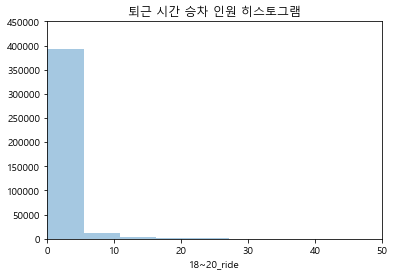

In [17]:
# 타깃 변수(퇴근시간 승차인원) 분포 시각화
sns.distplot(traindata['18~20_ride'], kde=False, bins=50)
plt.axis([0, 50, 0, 450000]) # [x 축 최솟값, x 축 최댓값, y 축 최솟값, y 축 최댓값]
plt.title('퇴근 시간 승차 인원 히스토그램') # 그래프 제목 지정
plt.show() # 그래프 그리기

In [18]:
# 타깃 변수(퇴근시간 승차인원) 분포 확인
traindata.groupby('18~20_ride').size().head(6)

18~20_ride
0.0    296528
1.0     44268
2.0     23752
3.0     13560
4.0      8630
5.0      5911
dtype: int64

- **단일 변수에 따른 타깃 변수의 변화**
- 특정 변수에 따른 타깃 변수의 변화가 유의미하다면 타깃 변수를 예측하는 데 영향을 끼칠 수 있는 변수일 확률이 높음
- 변수와 관련된 여러 파생변수를 만드는 것은 성능 향상에 좋은 방법
- 학습 데이터의 단일 변수에 따라 타깃 변수의 분포가 어떻게 달라졌는지 살펴보겠음

- **요일에 따른 퇴근시간 평균 탑승객 수**
- 데이터에 날짜와 관련된 변수가 있으면 날짜형으로 바꿔주는 것이 좋음
    - 연도별, 월별 일별, 요일별 등 날짜와 관련한 분석을 진행할 수 있음
    - 다양한 날짜 및 시간 관련 파생 변수를 생성할 수 있기 때문임

In [19]:
# 요일 변수 생성

# 날짜 형으로 변환
traindata['date'] = pd.to_datetime(traindata['date'])
# 요일을 문자형으로 추출해 변수 생성
traindata['weekday'] = traindata['date'].dt.strftime('%a')

- 위 병령어로 월요일 = Mon, ... 으로 변환됨
- 시각화를 통해 요일에 따른 평균 탑승객 수를 그래프로 표현하고 어떤 차이가 있는지 알아보겠음

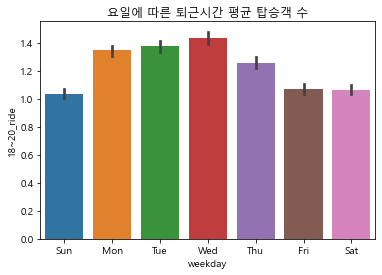

In [20]:
# 요일별 퇴근시간 평균 탑승객 수 시각화
sns.barplot(x='weekday', y='18~20_ride', data=traindata)
plt.title('요일에 따른 퇴근시간 평균 탑승객 수')
plt.show()

- 그래프를 분석해보면 월요일부터 수요일까지 퇴근시간 승차인원이 점차 증가하다가 수요일 이후에는 점차 감소하는 추세임

- **버스 종류에 따른 탑승객 수**
- 경진대회에서는 일별 및 버스 정류장별 버스 노선의 퇴근시간 승차 인원수를 예측해야함
- 시내버스인지 시외버스인지에 따라 퇴근시간 승차 인원수가 어떻게 되는지 확인해 보겠음

In [21]:
# 버스 종류별 퇴근시간 평균 탑승객 수 시각화
sns.barplot(x='in_out',y='18~20_ride',data=traindata)
plt.title('버스 종류에 따른 평균 탑승객 수')
plt.show()

- 시외버스는 평균적으로 약 2명이 탑승하는 것을 볼 수 있음
- 반면 시내버스는 평균적으로 1.3명이 탑승하는 것을 확인할 수 있음
- 시외, 시내 버스에 따라 사람 수에 차이가 있음을 확인할 수 있음

- **일별 출퇴근 시간 탑승객 수**
- 출근 시간(오전 8시 ~ 10시)과 퇴근 시간(18 ~ 20시)에 탑승객 수가 어떤 양상을 띠는지 확인해 보겠음
- 출근 시간의 승차 인원을 만들려면 기존의 데이터에서 출근 시간에 포함되는 8 ~ 9_ride와 9 ~ 10_ride 데이터를 합쳐야 함

In [22]:
# 일별 출퇴근 시간의 총 승차 인원 데이터 생성
traindata['8~10_ride'] = traindata['8~9_ride'] + traindata['9~10_ride']
eda_data = traindata.groupby('date')[['18~20_ride','8~10_ride']].agg('sum').reset_index()

# 상위 5개 행 확인
eda_data.head()

date  18~20_ride  8~10_ride
0 2019-09-01     11537.0    11957.0
1 2019-09-02     20561.0    21844.0
2 2019-09-03     19743.0    25756.0
3 2019-09-04     20133.0    21472.0
4 2019-09-05     20392.0    26331.0

In [23]:
# 일별 출퇴근 시간 탑승객 수 시각화
plt.plot('date','18~20_ride','g-',label='퇴근 시간 탑승객 수',data=eda_data)
plt.plot('date','8~10_ride','b-',label='출근 시간 탑승객 수',data=eda_data)
plt.gcf().autofmt_xdate() # x축의 라벨이 서로 겹치지 않도록 설정
plt.legend(loc=0) # 그래프 상에서 최적의 위치에 범례 표시
plt.title('일별 출퇴근 시간 탑승객 수')
plt.show()

- 시계열 자료라는 것을 알 수 있음
- 출근 시간의 탑승객 수가 퇴근 시간의 탑승객 수보다 많음
- 출퇴근 시간의 일별 탑승객 수는 비슷한 양상을 띠는 것을 확인할 수 있음

# 데이터 전처리

- 머신러닝 모델에 입력으로 사용할 변수를 만들겠음
- 타깃 변수에 영향을 끼치는 변수들을 생성하여 적절하게 데이터를 설명하는 것은 중요한 과정임
---
- 학습 데이터와 테스트 데이터가 동일한 변수를 가져가야함
- 학습 데이터와 테스트 데이터를 구분할 수 있는 cue 변수를 추가한 후 병합하여 변수를 생성함

In [23]:
# 학습 데이터와 테스트 데이터를 구분하기 위한 변수 생성
train['cue'] = 0
test['cue'] = 1

# 학습 데이터와 테스트 데이터 통합
df = pd.concat([train, test], axis=0)
df

id        date  bus_route_id in_out  station_code   station_name  \
0            0  2019-09-01       4270000     시외           344          제주썬호텔   
1            1  2019-09-01       4270000     시외           357           한라병원   
2            2  2019-09-01       4270000     시외           432           정존마을   
3            3  2019-09-01       4270000     시내          1579   제주국제공항(600번)   
4            4  2019-09-01       4270000     시내          1646       중문관광단지입구   
...        ...         ...           ...    ...           ...            ...   
228165  643588  2019-10-16      32820000     시내           786  고산환승정류장(고산1리)   
228166  643589  2019-10-16      32820000     시내          1080         애월고등학교   
228167  643590  2019-10-16      32820000     시내          1129   한림환승정류장(한림리)   
228168  643591  2019-10-16      32820000     시내          1564      제주시외버스터미널   
228169  643592  2019-10-16      32820000     시내       6115100     서귀포시외버스터미널   

        latitude  longitude  6~7_ride  7~8_ride  ...  10~11_ride  11~12_ride  \
0       33.48990  126.49373       0.0       1.0  ...         2.0         6.0   
1       33.48944  126.48508       1.0       4.0  ...         5.0         6.0   
2       33.48181  126.47352       1.0       1.0  ...         0.0         0.0   
3       33.50577  126.49252       0.0      17.0  ...        14.0        16.0   
4       33.25579  126.41260       0.0       0.0  ...         0.0         0.0   
...          ...        ...       ...       ...  ...         ...         ...   
228165  33.30073  126.18044       0.0       0.0  ...         0.0         0.0   
228166  33.46262  126.33447       0.0       0.0  ...         0.0         0.0   
228167  33.41437  126.26336       3.0       0.0  ...         0.0         0.0   
228168  33.49946  126.51479       3.0       0.0  ...         0.0         0.0   
228169  33.24873  126.50799       0.0       0.0  ...         0.0         0.0   

        6~7_takeoff  7~8_takeoff  8~9_takeoff  9~10_takeoff  10~11_takeoff  \
0               0.0          0.0          0.0           0.0            0.0   
1               0.0          0.0          0.0           0.0            0.0   
2               0.0          0.0          0.0           0.0            0.0   
3               0.0          0.0          0.0           0.0            0.0   
4               0.0          0.0          0.0           1.0            0.0   
...             ...          ...          ...           ...            ...   
228165          0.0          3.0          0.0           0.0            0.0   
228166          1.0          0.0          0.0           0.0            0.0   
228167          0.0          0.0          0.0           0.0            0.0   
228168          0.0          0.0          0.0           0.0            0.0   
228169          0.0          0.0          3.0           0.0            0.0   

        11~12_takeoff  18~20_ride  cue  
0                 0.0         0.0    0  
1                 0.0         5.0    0  
2                 0.0         2.0    0  
3                 0.0        53.0    0  
4                 0.0         0.0    0  
...               ...         ...  ...  
228165            0.0         NaN    1  
228166            0.0         NaN    1  
228167            0.0         NaN    1  
228168            0.0         NaN    1  
228169            0.0         NaN    1  

[643593 rows x 22 columns]

## 내부 데이터를 통한 변수 생성

- _**탐색적 데이터 분석을 통한 변수**
- **요일을 나타내는 변수(weekday)**
- 요일에 따른 퇴근시간 평균 탑승객 수 분석
- 월요일 ~ 수요일에는 퇴근시간 평균 탑승객 수가 점차 증가하다가 목요일~일요일에 감소하는 추세를 보임
    - 이러한 특성을 반영하기 위해 weekday 변수를 생성

In [24]:
# datetime 변수형으로 변환
df['date'] = pd.to_datetime(df['date'])
df

id       date  bus_route_id in_out  station_code   station_name  \
0            0 2019-09-01       4270000     시외           344          제주썬호텔   
1            1 2019-09-01       4270000     시외           357           한라병원   
2            2 2019-09-01       4270000     시외           432           정존마을   
3            3 2019-09-01       4270000     시내          1579   제주국제공항(600번)   
4            4 2019-09-01       4270000     시내          1646       중문관광단지입구   
...        ...        ...           ...    ...           ...            ...   
228165  643588 2019-10-16      32820000     시내           786  고산환승정류장(고산1리)   
228166  643589 2019-10-16      32820000     시내          1080         애월고등학교   
228167  643590 2019-10-16      32820000     시내          1129   한림환승정류장(한림리)   
228168  643591 2019-10-16      32820000     시내          1564      제주시외버스터미널   
228169  643592 2019-10-16      32820000     시내       6115100     서귀포시외버스터미널   

        latitude  longitude  6~7_ride  7~8_ride  ...  10~11_ride  11~12_ride  \
0       33.48990  126.49373       0.0       1.0  ...         2.0         6.0   
1       33.48944  126.48508       1.0       4.0  ...         5.0         6.0   
2       33.48181  126.47352       1.0       1.0  ...         0.0         0.0   
3       33.50577  126.49252       0.0      17.0  ...        14.0        16.0   
4       33.25579  126.41260       0.0       0.0  ...         0.0         0.0   
...          ...        ...       ...       ...  ...         ...         ...   
228165  33.30073  126.18044       0.0       0.0  ...         0.0         0.0   
228166  33.46262  126.33447       0.0       0.0  ...         0.0         0.0   
228167  33.41437  126.26336       3.0       0.0  ...         0.0         0.0   
228168  33.49946  126.51479       3.0       0.0  ...         0.0         0.0   
228169  33.24873  126.50799       0.0       0.0  ...         0.0         0.0   

        6~7_takeoff  7~8_takeoff  8~9_takeoff  9~10_takeoff  10~11_takeoff  \
0               0.0          0.0          0.0           0.0            0.0   
1               0.0          0.0          0.0           0.0            0.0   
2               0.0          0.0          0.0           0.0            0.0   
3               0.0          0.0          0.0           0.0            0.0   
4               0.0          0.0          0.0           1.0            0.0   
...             ...          ...          ...           ...            ...   
228165          0.0          3.0          0.0           0.0            0.0   
228166          1.0          0.0          0.0           0.0            0.0   
228167          0.0          0.0          0.0           0.0            0.0   
228168          0.0          0.0          0.0           0.0            0.0   
228169          0.0          0.0          3.0           0.0            0.0   

        11~12_takeoff  18~20_ride  cue  
0                 0.0         0.0    0  
1                 0.0         5.0    0  
2                 0.0         2.0    0  
3                 0.0        53.0    0  
4                 0.0         0.0    0  
...               ...         ...  ...  
228165            0.0         NaN    1  
228166            0.0         NaN    1  
228167            0.0         NaN    1  
228168            0.0         NaN    1  
228169            0.0         NaN    1  

[643593 rows x 22 columns]

In [25]:
# 요일 추출 (0~월요일~6~일요일)
df['weekday'] = df['date'].dt.weekday
df

id       date  bus_route_id in_out  station_code   station_name  \
0            0 2019-09-01       4270000     시외           344          제주썬호텔   
1            1 2019-09-01       4270000     시외           357           한라병원   
2            2 2019-09-01       4270000     시외           432           정존마을   
3            3 2019-09-01       4270000     시내          1579   제주국제공항(600번)   
4            4 2019-09-01       4270000     시내          1646       중문관광단지입구   
...        ...        ...           ...    ...           ...            ...   
228165  643588 2019-10-16      32820000     시내           786  고산환승정류장(고산1리)   
228166  643589 2019-10-16      32820000     시내          1080         애월고등학교   
228167  643590 2019-10-16      32820000     시내          1129   한림환승정류장(한림리)   
228168  643591 2019-10-16      32820000     시내          1564      제주시외버스터미널   
228169  643592 2019-10-16      32820000     시내       6115100     서귀포시외버스터미널   

        latitude  longitude  6~7_ride  7~8_ride  ...  11~12_ride  6~7_takeoff  \
0       33.48990  126.49373       0.0       1.0  ...         6.0          0.0   
1       33.48944  126.48508       1.0       4.0  ...         6.0          0.0   
2       33.48181  126.47352       1.0       1.0  ...         0.0          0.0   
3       33.50577  126.49252       0.0      17.0  ...        16.0          0.0   
4       33.25579  126.41260       0.0       0.0  ...         0.0          0.0   
...          ...        ...       ...       ...  ...         ...          ...   
228165  33.30073  126.18044       0.0       0.0  ...         0.0          0.0   
228166  33.46262  126.33447       0.0       0.0  ...         0.0          1.0   
228167  33.41437  126.26336       3.0       0.0  ...         0.0          0.0   
228168  33.49946  126.51479       3.0       0.0  ...         0.0          0.0   
228169  33.24873  126.50799       0.0       0.0  ...         0.0          0.0   

        7~8_takeoff  8~9_takeoff  9~10_takeoff  10~11_takeoff  11~12_takeoff  \
0               0.0          0.0           0.0            0.0            0.0   
1               0.0          0.0           0.0            0.0            0.0   
2               0.0          0.0           0.0            0.0            0.0   
3               0.0          0.0           0.0            0.0            0.0   
4               0.0          0.0           1.0            0.0            0.0   
...             ...          ...           ...            ...            ...   
228165          3.0          0.0           0.0            0.0            0.0   
228166          0.0          0.0           0.0            0.0            0.0   
228167          0.0          0.0           0.0            0.0            0.0   
228168          0.0          0.0           0.0            0.0            0.0   
228169          0.0          3.0           0.0            0.0            0.0   

        18~20_ride  cue  weekday  
0              0.0    0        6  
1              5.0    0        6  
2              2.0    0        6  
3             53.0    0        6  
4              0.0    0        6  
...            ...  ...      ...  
228165         NaN    1        2  
228166         NaN    1        2  
228167         NaN    1        2  
228168         NaN    1        2  
228169         NaN    1        2  

[643593 rows x 23 columns]

- 위 코드를 실행한 결과 숫자형인 weekday 변수를 생성함
- 요일에 따라 0~6까지 숫자가 부여됨

In [26]:
df[['weekday']].head()

weekday
0        6
1        6
2        6
3        6
4        6

- **요일별 평균 탑승객 수**
- 요일과 함께 해당 요일의 평균 탑승객 수라는 정보가 더해진다면 모델이 요일별 특성을 잘 학습할 수 있을 것임
- 이러한 특성을 반영하기 위해 weekdaymean 변수를 생성함

In [27]:
# 요일별 평균 탑승객 수를 구하는 함수
def week_mean():
    # 전체 데이터에서 train 데이터에 해당하는 행을 추출
    train_data = df.query('cue==0').reset_index(drop=True)
    
    # 일괄적으로 1의 값을 가지는 'weekdaymean'변수 생성
    df['weekdaymean'] = 1
    
    # 각 요일에 해당하는 인덱스 추출
    index0 = df.query('weekday==0').index
    index1 = df.query('weekday==1').index
    index2 = df.query('weekday==2').index
    index3 = df.query('weekday==3').index
    index4 = df.query('weekday==4').index
    index5 = df.query('weekday==5').index
    index6 = df.query('weekday==6').index
    
    # 인덱스를 활용해 'weekdaymean'의 값을 각 요일에 맞는 평균 탑승 탑승객 수로 변경
    df.iloc[index0,-1] = train_data.query('weekday==0')['18~20_ride'].mean()
    df.iloc[index1,-1] = train_data.query('weekday==1')['18~20_ride'].mean()
    df.iloc[index2,-1] = train_data.query('weekday==2')['18~20_ride'].mean()
    df.iloc[index3,-1] = train_data.query('weekday==3')['18~20_ride'].mean()
    df.iloc[index4,-1] = train_data.query('weekday==4')['18~20_ride'].mean()
    df.iloc[index5,-1] = train_data.query('weekday==5')['18~20_ride'].mean()
    df.iloc[index6,-1] = train_data.query('weekday==6')['18~20_ride'].mean()
    
    return df

# 함수를 실행하여 변수 생성
df = week_mean()
df

id       date  bus_route_id in_out  station_code   station_name  \
0            0 2019-09-01       4270000     시외           344          제주썬호텔   
1            1 2019-09-01       4270000     시외           357           한라병원   
2            2 2019-09-01       4270000     시외           432           정존마을   
3            3 2019-09-01       4270000     시내          1579   제주국제공항(600번)   
4            4 2019-09-01       4270000     시내          1646       중문관광단지입구   
...        ...        ...           ...    ...           ...            ...   
228165  643588 2019-10-16      32820000     시내           786  고산환승정류장(고산1리)   
228166  643589 2019-10-16      32820000     시내          1080         애월고등학교   
228167  643590 2019-10-16      32820000     시내          1129   한림환승정류장(한림리)   
228168  643591 2019-10-16      32820000     시내          1564      제주시외버스터미널   
228169  643592 2019-10-16      32820000     시내       6115100     서귀포시외버스터미널   

        latitude  longitude  6~7_ride  7~8_ride  ...  6~7_takeoff  \
0       33.48990  126.49373       0.0       1.0  ...          0.0   
1       33.48944  126.48508       1.0       4.0  ...          0.0   
2       33.48181  126.47352       1.0       1.0  ...          0.0   
3       33.50577  126.49252       0.0      17.0  ...          0.0   
4       33.25579  126.41260       0.0       0.0  ...          0.0   
...          ...        ...       ...       ...  ...          ...   
228165  33.30073  126.18044       0.0       0.0  ...          0.0   
228166  33.46262  126.33447       0.0       0.0  ...          1.0   
228167  33.41437  126.26336       3.0       0.0  ...          0.0   
228168  33.49946  126.51479       3.0       0.0  ...          0.0   
228169  33.24873  126.50799       0.0       0.0  ...          0.0   

        7~8_takeoff  8~9_takeoff  9~10_takeoff  10~11_takeoff  11~12_takeoff  \
0               0.0          0.0           0.0            0.0            0.0   
1               0.0          0.0           0.0            0.0            0.0   
2               0.0          0.0           0.0            0.0            0.0   
3               0.0          0.0           0.0            0.0            0.0   
4               0.0          0.0           1.0            0.0            0.0   
...             ...          ...           ...            ...            ...   
228165          3.0          0.0           0.0            0.0            0.0   
228166          0.0          0.0           0.0            0.0            0.0   
228167          0.0          0.0           0.0            0.0            0.0   
228168          0.0          0.0           0.0            0.0            0.0   
228169          0.0          3.0           0.0            0.0            0.0   

        18~20_ride  cue  weekday  weekdaymean  
0              0.0    0        6     1.034282  
1              5.0    0        6     1.034282  
2              2.0    0        6     1.034282  
3             53.0    0        6     1.034282  
4              0.0    0        6     1.034282  
...            ...  ...      ...          ...  
228165         NaN    1        2     1.000000  
228166         NaN    1        2     1.000000  
228167         NaN    1        2     1.000000  
228168         NaN    1        2     1.000000  
228169         NaN    1        2     1.000000  

[643593 rows x 24 columns]

- 위 코드를 실행한 결과 숫자형인 weekdaymean 변수를 생성함
- 요일별 탑승객 수의 평균 값이 들어간 것을 확인할 수 있음

In [28]:
df[['weekdaymean']].head()

weekdaymean
0     1.034282
1     1.034282
2     1.034282
3     1.034282
4     1.034282

- **버스 종류별 평균 탑승객 수 (in_out_mean)**
- 평균 탑승객 수가 달라지는 것을 확인했음
- 버스 종류를 나타내는 in_out 변수와 함께 버스 종류별 평균 탑승객 수라는 정보가 더해진다면 버스 종류별 특성을 잘 반영할 수 있을 것임
- 버스 종류별 평균 탑승객 수를 나타내는 in_out_mean 변수를 생성함

In [29]:
# 버스 종류별 평균 탑승객 수를 구하는 함수
def inout_mean():
    # 전체 데이터에서 train 데이터에 해당하는 행 추출
    train_data = df.query('cue==0').reset_index(drop=True)
    
    # 일괄적으로 1의 값을 가지는 in_out_mean 변수 생성
    df['in_out_mean'] = 1
    
    # 버스 종류별 인덱스 추출
    in_index = df.query('in_out == "시내"').index # 시내버스
    out_index = df.query('in_out == "시외"').index # 시외버스
    
    # 인덱스를 활용하여 in_out_mean의 값을 각 버스 종류에 맞는 평균 탑승 승객 수로 변경
    df.iloc[in_index,-1] = train_data.query('in_out == "시내"')['18~20_ride'].mean()
    df.iloc[out_index,-1] = train_data.query('in_out == "시외"')['18~20_ride'].mean()
    
    return df

# 함수를 실행하여 변수 생성
df = inout_mean()
df

id       date  bus_route_id in_out  station_code   station_name  \
0            0 2019-09-01       4270000     시외           344          제주썬호텔   
1            1 2019-09-01       4270000     시외           357           한라병원   
2            2 2019-09-01       4270000     시외           432           정존마을   
3            3 2019-09-01       4270000     시내          1579   제주국제공항(600번)   
4            4 2019-09-01       4270000     시내          1646       중문관광단지입구   
...        ...        ...           ...    ...           ...            ...   
228165  643588 2019-10-16      32820000     시내           786  고산환승정류장(고산1리)   
228166  643589 2019-10-16      32820000     시내          1080         애월고등학교   
228167  643590 2019-10-16      32820000     시내          1129   한림환승정류장(한림리)   
228168  643591 2019-10-16      32820000     시내          1564      제주시외버스터미널   
228169  643592 2019-10-16      32820000     시내       6115100     서귀포시외버스터미널   

        latitude  longitude  6~7_ride  7~8_ride  ...  7~8_takeoff  \
0       33.48990  126.49373       0.0       1.0  ...          0.0   
1       33.48944  126.48508       1.0       4.0  ...          0.0   
2       33.48181  126.47352       1.0       1.0  ...          0.0   
3       33.50577  126.49252       0.0      17.0  ...          0.0   
4       33.25579  126.41260       0.0       0.0  ...          0.0   
...          ...        ...       ...       ...  ...          ...   
228165  33.30073  126.18044       0.0       0.0  ...          3.0   
228166  33.46262  126.33447       0.0       0.0  ...          0.0   
228167  33.41437  126.26336       3.0       0.0  ...          0.0   
228168  33.49946  126.51479       3.0       0.0  ...          0.0   
228169  33.24873  126.50799       0.0       0.0  ...          0.0   

        8~9_takeoff  9~10_takeoff  10~11_takeoff  11~12_takeoff  18~20_ride  \
0               0.0           0.0            0.0            0.0         0.0   
1               0.0           0.0            0.0            0.0         5.0   
2               0.0           0.0            0.0            0.0         2.0   
3               0.0           0.0            0.0            0.0        53.0   
4               0.0           1.0            0.0            0.0         0.0   
...             ...           ...            ...            ...         ...   
228165          0.0           0.0            0.0            0.0         NaN   
228166          0.0           0.0            0.0            0.0         NaN   
228167          0.0           0.0            0.0            0.0         NaN   
228168          0.0           0.0            0.0            0.0         NaN   
228169          3.0           0.0            0.0            0.0         NaN   

        cue  weekday  weekdaymean  in_out_mean  
0         0        6     1.034282     2.044345  
1         0        6     1.034282     2.044345  
2         0        6     1.034282     2.044345  
3         0        6     1.034282     1.228499  
4         0        6     1.034282     1.228499  
...     ...      ...          ...          ...  
228165    1        2     1.000000     1.000000  
228166    1        2     1.000000     1.000000  
228167    1        2     1.000000     1.000000  
228168    1        2     1.000000     1.000000  
228169    1        2     1.000000     1.000000  

[643593 rows x 25 columns]

In [30]:
df[['in_out_mean']].head()

in_out_mean
0     2.044345
1     2.044345
2     2.044345
3     1.228499
4     1.228499

- **일별 오전 시간대의 총 탑승객 수**
- 일별 출근시간 탑승객 수와 퇴근시간 탑승객 수가 비슷한 양상을 띠는 것을 확인했음
- 일별 오전 시간대의 탑승객 수는 해당하는 날짜의 퇴근 시간 탑승객 수에 영향을 줄 수 있음
    - 따라서 6 ~ 7_ride_sum, 7 ~ 8_ride_sum, 8 ~ 9_ride_sum, 9 ~ 10_ride_sum, 10 ~ 11_ride_sum 변수를 생성

In [31]:
# 날짜별 오전 시간에 탑승한 총 탑승객 수
f = df.groupby('date')['6~7_ride','7~8_ride','8~9_ride','9~10_ride','10~11_ride'].sum().reset_index()

# 변수명 변경
f.columns= ['date','6~7_ride_sum', '7~8_ride_sum', '8~9_ride_sum', '9~10_ride_sum', '10~11_ride_sum']

# 기존 데이터프레임에 새로운 변수 병합
df = pd.merge(df,f,how='left',on='date')
df

id       date  bus_route_id in_out  station_code   station_name  \
0            0 2019-09-01       4270000     시외           344          제주썬호텔   
1            1 2019-09-01       4270000     시외           357           한라병원   
2            2 2019-09-01       4270000     시외           432           정존마을   
3            3 2019-09-01       4270000     시내          1579   제주국제공항(600번)   
4            4 2019-09-01       4270000     시내          1646       중문관광단지입구   
...        ...        ...           ...    ...           ...            ...   
643588  643588 2019-10-16      32820000     시내           786  고산환승정류장(고산1리)   
643589  643589 2019-10-16      32820000     시내          1080         애월고등학교   
643590  643590 2019-10-16      32820000     시내          1129   한림환승정류장(한림리)   
643591  643591 2019-10-16      32820000     시내          1564      제주시외버스터미널   
643592  643592 2019-10-16      32820000     시내       6115100     서귀포시외버스터미널   

        latitude  longitude  6~7_ride  7~8_ride  ...  18~20_ride  cue  \
0       33.48990  126.49373       0.0       1.0  ...         0.0    0   
1       33.48944  126.48508       1.0       4.0  ...         5.0    0   
2       33.48181  126.47352       1.0       1.0  ...         2.0    0   
3       33.50577  126.49252       0.0      17.0  ...        53.0    0   
4       33.25579  126.41260       0.0       0.0  ...         0.0    0   
...          ...        ...       ...       ...  ...         ...  ...   
643588  33.30073  126.18044       0.0       0.0  ...         NaN    1   
643589  33.46262  126.33447       0.0       0.0  ...         NaN    1   
643590  33.41437  126.26336       3.0       0.0  ...         NaN    1   
643591  33.49946  126.51479       3.0       0.0  ...         NaN    1   
643592  33.24873  126.50799       0.0       0.0  ...         NaN    1   

        weekday  weekdaymean  in_out_mean  6~7_ride_sum  7~8_ride_sum  \
0             6     1.034282     2.044345        2942.0        4518.0   
1             6     1.034282     2.044345        2942.0        4518.0   
2             6     1.034282     2.044345        2942.0        4518.0   
3             6     1.034282     1.228499        2942.0        4518.0   
4             6     1.034282     1.228499        2942.0        4518.0   
...         ...          ...          ...           ...           ...   
643588        2     1.000000     1.000000        4771.0       14195.0   
643589        2     1.000000     1.000000        4771.0       14195.0   
643590        2     1.000000     1.000000        4771.0       14195.0   
643591        2     1.000000     1.000000        4771.0       14195.0   
643592        2     1.000000     1.000000        4771.0       14195.0   

        8~9_ride_sum  9~10_ride_sum  10~11_ride_sum  
0             5682.0         6275.0          6774.0  
1             5682.0         6275.0          6774.0  
2             5682.0         6275.0          6774.0  
3             5682.0         6275.0          6774.0  
4             5682.0         6275.0          6774.0  
...              ...            ...             ...  
643588       12602.0         9143.0          7757.0  
643589       12602.0         9143.0          7757.0  
643590       12602.0         9143.0          7757.0  
643591       12602.0         9143.0          7757.0  
643592       12602.0         9143.0          7757.0  

[643593 rows x 30 columns]

- 위 코드를 실행한 결과 변수 5개를 생성하였음.
- 6시부터 11시까지 한 시간 간격으로 오전 시간대의 탑승객 수의 평균값이 들어간 것을 확인

In [32]:
df[['date','6~7_ride_sum', '7~8_ride_sum', '8~9_ride_sum', '9~10_ride_sum', '10~11_ride_sum']].head()

date  6~7_ride_sum  7~8_ride_sum  8~9_ride_sum  9~10_ride_sum  \
0 2019-09-01        2942.0        4518.0        5682.0         6275.0   
1 2019-09-01        2942.0        4518.0        5682.0         6275.0   
2 2019-09-01        2942.0        4518.0        5682.0         6275.0   
3 2019-09-01        2942.0        4518.0        5682.0         6275.0   
4 2019-09-01        2942.0        4518.0        5682.0         6275.0   

   10~11_ride_sum  
0          6774.0  
1          6774.0  
2          6774.0  
3          6774.0  
4          6774.0

- **도메인 조사를 통한 변수**
- 데이터를 잘 설명해줄 수 있는 효율적인 변수 생성을 하기 위해선 도메인 지식이 중요함
---
- **배차 간격**
- 버스 배차 간격 : 일정 시간 간격으로 버스를 배치할 때 이전 버스와의 시간 간격으로, 수요가 많은 버스는 차량을 많이 투입해 배차 간격을 줄이기도 함
    - 배차 간격이 짧으면 수요가 많은 버스임을 유추 가능
        - 이러한 특성을 반영하기 위해 bus_interval 변수를 생성
        

- 탑승 날짜, 탑승 정류장 코드, 탑승 노선 번호가 모두 같고 i번째 탑승객과 i+1번째 탑승객의 탑승 시간이 일정한 시간 차이가 있다면 그 차이가 배차 간격이라고 추정 가능

**굳이 다 돌릴 필요 없음**

In [33]:
# 탑승 날짜를 datetime 형으로 변환
bts['geton_time2']= pd.to_datetime(bts['geton_time'])

# 탑승 날짜, 탑승 정류장 코드, 탑승 노선 번호 기준으로 정렬
f = bts.sort_values(by=['geton_date','geton_station_code','bus_route_id','geton_time2'],ascending=True).reset_index()

KeyboardInterrupt: 

In [ ]:
f

In [ ]:
# 반복문 실행 시간이 많이 소요되어 상태 진행률을 확인할 수 있는 tqdm 라이브러리 사용
from tqdm import notebook

# 시차를 넣기 위한 빈 리스트 생성
interval_lst =[]
for i in notebook.tqdm(range(0,len(f)-1)):
    # 탑승 날짜, 탑승 정류장 코드, 탑승 노선 번호가 같다면
    if ((f.iloc[i].geton_date == f.iloc[i+1].geton_date) &
       (f.iloc[i].geton_station_code == f.iloc[i+1].geton_station_code) &
       (f.iloc[i].bus_route_id == f.iloc[i+1].bus_route_id)):
        # 탑승 날짜의 차를 interval_lst에 넣기
        interval_lst.append(f.iloc[i+1].geton_time2-f.iloc[i].geton_time2)
    else:
        # 같지 않다면 0을 interval_lst에 넣기
        interval_lst.append(0)
# 다르면 다른 버스에 탑승한 것이므로 0을 추가함
interval_lst.insert(0,'0')

In [ ]:
interval_lst

In [ ]:
# 위 과정을 마치면 interval_list에 0 days 01:56:32 또는 0과 같은 형태의 값이 저장됨
# 통일시키기 위해 시:분:초로 변환

f['interval'] = interval_lst # interval_lst를 interval 변수로 생성
# interval 변수의 값을 문자형으로 변환 후 시:분:초 형태로 변환
f['interval'] = f['interval'].astype(str).str[7:].replace('','00:00:00')
f['bus_route_id'] = f['bus_route_id'].astype(object)

In [ ]:
# interval 변수의 값을 분으로 변환하는 get_min() 함수를 정의함
# 함수를 통해 나온 결괏값을 60으로 나눠 분을 계산하고 time 변수에 저장함
# time 값이 너무 작으면 같은 버스에 탑승한 것을 의미함
# 값이 너무 크면 자정이 넘어 운영한 마지막 버스와 첫 번째 버스 사이의 시차를 구했다고 판단할 수 있음
# time의 값이 3분보다 작거나 3시간보다 큰 데이터는 삭제함

# 분으로 변환하는 함수
def get_min(time_str):
    h, m, s = time_str.split(':')
    return (int(h) * 3600 + int(m) * 60 + int(s)) / 60

# interval 함수의 모든 값에 대해 함수 적용하여 나온 값을 time 리스트에 넣기
time = []
for i in f['interval']:
    time.append(get_min(i))
    
f['time'] = time # time 리스트를 time 변수로 생성
f['time'] = f['time'].astype(int) # time 변수를 int 타입으로 변경
f = f[f['time'] > 3] # 간격이 3분보다 작은 것 제외
f = f[f['time'] < 180] # 간격이 3시간보다 큰 것 제외
f

In [54]:
# bus_route_id 별로 time의 평균값을 bus_interval 변수로 저장하고, 정수 형식으로 타입을 변환함
# 배차 간격 변수는 생성하는 데 많은 시간이 소요되므로 첫 번째 수행 시에 bus_interval.csv 파일로 저장한 뒤, 이후에는 미리 저장해둔 csv 파일을 사용함

# 버스 노선별 버스 간격의 평균 bus_interval 변수 생성
data = f.groupby('bus_route_id')['time'].agg([('bus_interval','mean')]).reset_index()
data['bus_interval'] = data['bus_interval'].astype(int)

# 변수 생성에 많은 시간이 소요되므로 csv 파일로 저장
data.to_csv('bus_interval.csv', index=False)

- 데이터를 병합하면 df에는 있지만 bus_bts 데이터에는 없는 노선 번호가 있어 결측치가 생김
- 배차 간격이 짧을수록 수요가 많은 버스임을 의미함므로 결측치를 0으로 채우는 것은 변수 생성 목적과 맞지 않음
- 따라서 결측치를 9999로 변경

- **여기까지 다 돌릴 필요 없음**

In [33]:
# csv 파일이 성공적으로 저장됐다면 다음 과정부터 진행
import numpy as np
df['bus_route_id'] = df['bus_route_id'].astype(np.int64)
bus_interval = pd.read_csv('bus_interval.csv')

# 기존의 데이터프레임에 새로운 변수를 병합
df = pd.merge(df, bus_interval, how='left', on='bus_route_id')
df['bus_interval'] = df['bus_interval'].fillna(9999) # 병합 중 생기는 NA 값 처리

- 위 코드를 실행한 결과 숫자형인 bus_interval 변수를 생성했음
- 버스 노선 번호에 따른 배차 간격이 들어간 것을 확인할 수 있음

In [34]:
df[['bus_interval']].head()
# df.sample(n=2)

bus_interval
0          34.0
1          34.0
2          34.0
3          34.0
4          34.0

- **수요가 많을 것으로 에상되는 정류장**
- 퇴근 시간에는 직장인 유동인구뿐만 아니라 하교하는 학생 유동인구도 함께 늘어남
- 학교 근처 정류장에 수요가 많아지며 이는 버스 퇴근시간 승차인원에 영향을 줄 수 있음
- 따라서 정류장명을 통해 고등학교와 대학교 근처 정류장을 구분하는 school 변수를 생성

In [35]:
# school 변수 생성
# 정류장명에 '고등학교'가 포함되어 있는 행 뽑기
highschool_station = df[df['station_name'].str.contains('고등학교')]
# '고등학교'가 포함되어 있는 정류장명을 중복 없이 리스트에 저장
highschool = list(highschool_station['station_name'].unique())
# 정류장명에 '대학교'가 포함되어 있는 행 뽑기
university_station = df[df['station_name'].str.contains('대학교')]
# '대학교'가 포함되어 있는 정류장명을 중복 없이 리스트에 저장
university = list(university_station['station_name'].unique())

# '고등학교'와 '대학교' 근처 정류장 구분 함수
def schoolstation(x):
    # highschool 리스트에 정류장명이 포함되어 있다면 1을 반환
    if x in highschool:
        return 1
    # university 리스트에 정류장명이 포함되어 있다면 1을 반환
    elif x in university:
        return 1
    # 둘다 포함되지 않는 정류장명이라면 0을 반환
    else:
        return 0
        
# 모든 정류장명에 대해 적용
df['school'] = df['station_name'].apply(schoolstation)

In [36]:
highschool

['오현중고등학교',
 '신흥리(마을입구)함덕고등학교',
 '한림고등학교',
 '애월고등학교',
 '중문고등학교',
 '제주중앙여자고등학교(아라방면)',
 '제주여자중고등학교(아라방면)',
 '제주여자중고등학교(광양방면)',
 '표선고등학교',
 '월랑마을남녕고등학교',
 '남녕고등학교',
 '서귀포산업과학고등학교',
 '제주중앙여자고등학교(광양방면)',
 '제주여자상업고등학교',
 '제주고등학교/중흥S클래스',
 '삼성여자고등학교',
 '제주고등학교',
 '제주제일고등학교',
 '제주여자중고등학교',
 '제주여자중고등학교제주지방해양경찰청',
 '서귀포여자고등학교',
 '대기고등학교',
 '신성여자중고등학교',
 '제주중앙고등학교',
 '서귀포고등학교',
 '남주중고등학교',
 '상도리세화고등학교',
 '성산고등학교',
 '세화고등학교',
 '대정고등학교',
 '영주고등학교']

In [37]:
university

['제주대학교병원',
 '제주대학교입구',
 '제주국제대학교',
 '제주대학교',
 '제주한라대학교',
 '제주대학교교육대학',
 '제주한라대학교(종점)']

In [38]:
df[['school']].head()

school
0       0
1       0
2       0
3       0
4       0

- 환승 정류장도 수요가 많을 것으로 예상되는 정류장임
- 환승 정류장은 일반 승객뿐만 아니라 시내, 시외 버스 같은 대중교통이나 비행기로 환승하고자 하는 승객 또한 이용하므로 하차 승객 수가 많을 것임
- transfer 변수 생성 과정은 school 변수 생성 과정과 비슷함
- 다만 str.contains() 명령어를 사용할 때 정류장 이름에 '환숭', '공항', '터미널'이 들어 있는 행을 추출한다는 점만 다름

In [39]:
# school 변수와 동일한 방법으로 transfer 변수 생성
transfer_station = df[df['station_name'].str.contains('환승')]
transfers = list(transfer_station['station_name'].unique())

airport_station = df[df['station_name'].str.contains('공항')]
airport = list(airport_station['station_name'].unique())

terminal_station = df[df['station_name'].str.contains('터미널')]
terminal = list(terminal_station['station_name'].unique())

# 항상 수요가 많은 정류장 구분 함수
def transfer_station(x):
    if x in transfers:
        return 1
    elif x in airport:
        return 1
    elif x in terminal:
        return 1
    else:
        return 0
    
df['transfer'] = df['station_name'].apply(transfer_station)

In [40]:
df[['transfer']].head()

transfer
0         0
1         0
2         0
3         1
4         0

- **연휴(holiday)**
- 학습 데이터는 추석, 테스트 데이터는 개천절, 한글날의 연휴 기간을 포함하고 있음
- 연휴 기간에는 학교와 회사에 가지 않으므로 퇴근 시간에 평소와 다른 수요 패턴이 나타나며, 이는 버스 퇴근 시간 승차 인원에 영향을 줄 수 있음
- 이러한 특성을 반영하기 위해 holiday 변수를 생성함

In [41]:
# 날짜에서 연휴 구분 함수
def holiday_function(x):
    # 공휴일이라면 1을 반환
    if x in ['2019-09-12','2019-09-13','2019-09-14','2019-10-03','2019-10-09']:
        return 1
    else:
        # 공휴일이 아니라면 0을 반환
        return 0
    
# 모든 날짜에 적용
df['holiday'] = df['date'].apply(holiday_function)

- 숫자형인 holiday를 생성함
- 연휴인 날짜는 1, 연후가 아닌 날짜는 0의 값을 가진 것을 확인

In [42]:
df[['holiday']].head()

holiday
0        0
1        0
2        0
3        0
4        0

- **시간대를 활용한 변수**
- 경진대회 과제는 오전 시간(6~12)의 데이터만으로 퇴근 시간의 버스 승차 인원을 예측해야 함
- 따라서 오전 시간대를 활용해 변수를 만드는 방법을 소개함
---
- **t ~ t+2 승하차 시간대 통합 변수(68a, 810a, 1012a, 68b, 810b, 1012b)**
- 기존 학습 데이터의 오전 시간대는 1시간마다 승하차 인원수를 표시하고 있음
    - 하지만 예측하려는 퇴근 시간대는 18시부터 20시까지 2시간에 해당하는 승차 인원을 예측해야함
        - 따라서 2시간 간격으로 승하차 시간대를 통합한 변수를 생성함
        

- 승차와 하차의 구분을 위해 승차 인원을 나타내는 변수명의 맨 마지막에는 a를 붙임
- 하차 인원을 나타내는 변수명의 맨 마지막에는 b를 붙여 변수명을 통일함

In [43]:
# 오전 시간대에 2시간 동안 승차한 인원수의 합계
df['68a'] = df['6~7_ride']+df['7~8_ride']
df['810a'] = df['8~9_ride']+df['9~10_ride']
df['1012a'] = df['10~11_ride']+df['11~12_ride']

# 오전 시간대에 2시간 동안 하차한 인원수의 합계
df['68b'] = df['6~7_takeoff'] + df['7~8_takeoff']
df['810b'] = df['8~9_takeoff'] + df['9~10_takeoff']
df['1012b'] = df['10~11_takeoff'] + df['11~12_takeoff']

- **오전 시간의 승객 수(ride_sum, takeoff_sum)**
- 오전 시간에 버스를 승하차한 승객 수가 많다면 퇴근 시간의 승차 인원도 증가할 것임
- 이와 같은 가정을 토대로 오전 시간대 승차 승객 수와 하차 승객 수의 합계와 평균을 나타내는 변수를 추가함
- 먼저 오전 시간에 승차한 승객 수의 합과 하차한 승객 수의 합을 구해 오전 시간대 승객 수를 통합한 ride_sum 변수와 takeoff_sum 변수를 생성함

In [44]:
# 오전 시간(6시~12시)에 승차한 승객 수의 합계
df['ride_sum'] = df[['6~7_ride','7~8_ride','8~9_ride','9~10_ride','10~11_ride','11~12_ride']].sum(axis=1)

# 오전 시간(6시~12시)에 하차한 승객 수의 합계
df['takeoff_sum'] = df[['6~7_takeoff','7~8_takeoff','8~9_takeoff','9~10_takeoff','10~11_takeoff','11~12_takeoff']].sum(axis=1)

df[['ride_sum','takeoff_sum']].head()

ride_sum  takeoff_sum
0      16.0          0.0
1      22.0          0.0
2       4.0          0.0
3      79.0          0.0
4       0.0          1.0

- 출퇴근 시간에 인기 있는 버스 노선이 존재하여 출근 시간 승차 인원이 버스 노선은 퇴근 시간 또한 승차 인원이 많을 것으로 예상할 수 있음
- 따라서 위에서 만든 변수에 '노선' 기준을 추가하여 '노선별 오전 시간대의 총,평균 탑승객 수'를 구하겠음
- 노선별 오전 시간의 총 탑승객 수를 나타내는 1012a_sum 변수와, 노선별 오전 시간의 평균 탑승객 수를 나타내는 1012a_mean 변수를 생성함

In [45]:
# bus_route_id와 station_code를 결합해 route_station 생성
df['route_station'] = df['bus_route_id'].astype(str) + ',' + df['station_code'].astype(str)

# 버스 노선별 오전 시간의 총 탑승객 수와 평균 탑승객 수 구하기
data = df.groupby(['route_station'])['1012a'].agg({'sum','mean'}).reset_index()

# 변수명을 1012a_sum, 1012a_mean으로 변경
data.rename(columns={'mean':'1012a_mean','sum':'1012a_sum'}, inplace=True)

# 기존 데이터프레임에 새로운 변수를 병합
df = pd.merge(df, data, how='left', on='route_station')

In [46]:
df[['1012a_mean','1012a_sum']].head()

1012a_mean  1012a_sum
0    5.304348      244.0
1   11.608696      534.0
2    2.304348      106.0
3   36.673913     1687.0
4    0.564103       22.0

- **bus_bts를 활용한 변수**
- 학습 데이터와 테스트 데이터의 X~Y_ride 변수의 합과 bus_bts 데이터의 user_count 변수의 합은 같음
- bus_bts.csv를 통해 탑승한 승객의 정보를 파악할 수 있음
- bus_bts 데이터에는 승객 구분을 해주는 user_category(01:일반, 02:어린이, 04:청소년, 06:경로, 27:장애 일반, 28:장애 동반, 29:유공 일, 30:유공 동반) 변수가 존재함
- 이 변수를 활용해 학습 데이터와 테스트 데이터에 카테고리별 승객 수의 합과 비율 변수를 추가해주겠음
---
- **카테고리별 승객 수의 합과 비율(adult, kids, teen, elder, adult_prop, kids_prop, teen_prop, elder_prop)**
- user_category 변수를 활용해 학습 데이터와 테스트 데이터에 승객 정보를 추가하면 특정 버스 정류장에 어떤 승객이 많이 탑승하는지 알 수 있음
- 회사 : 일반 승객, 중고등학교 근처 : 청소년 승객, 노인복지관 : 경로 승객이 상대적으로 높을 것임
- 퇴근 시간에는 일반, 청소년 승객이 많이 타는 버스에 탑승객 수가 많을 것으로 예상할 수 있음
- 따라서 bus_route_id와 카테고리별로 승객 수의 합과 비율 변수를 생성하겠음
- 먼저 user_category별 승객 수의 합을 구해 df와 병합하겠음

In [47]:
# 카페고리별 승객 수의 합
def category_people():
    # df와 병합을 위해 bus_route_id의 타입을 str로 통일
    bts['bus_route_id'] = bts['bus_route_id'].astype(str)
    
    # bus_route_id와 user_category별 승객 수의 합
    f = bts.groupby(['bus_route_id','user_category'])['user_count'].agg([('승객수','sum')]).reset_index()
    
    # bus_route_id별 user_category 변수의 승객 수의 피벗 테이블 형태로 변환
    g = pd.pivot_table(f, values='승객수', index='bus_route_id',
                      columns='user_category', fill_value=0).reset_index()
    g.columns = ['bus_route_id','adult','kids','teen','elder','jang','jang2','ugong','ugong2']
    g = g[['bus_route_id','adult','kids','teen','elder']]
    
    # 기존의 데이터프레임에 새로운 변수를 병합
    merge_data = pd.merge(df, g, how='left',  on='bus_route_id')
    
    return merge_data

# bus_route_id의 타입을 str로 통이시켜준 뒤, 함수를 실행하여 변수 생성
df['bus_route_id'] = df['bus_route_id'].astype(str)
df = category_people()

df[['adult','kids','teen','elder']].head()

adult  kids  teen  elder
0  8158.0  72.0  38.0    0.0
1  8158.0  72.0  38.0    0.0
2  8158.0  72.0  38.0    0.0
3  8158.0  72.0  38.0    0.0
4  8158.0  72.0  38.0    0.0

In [48]:
# 카테고리별 승객 수의 비율
def category_people_ratio():
    
    # bus_route_id별 user_category의 전체 합
    f_all = bts.groupby('bus_route_id')['user_count'].agg([('전체','sum')]).reset_index()
    
    # bus_route_id와 user_category별 승객 수의 합
    f_sum = bts.groupby(['bus_route_id','user_category'])['user_count'].agg([('승객수','sum')]).reset_index()
    
    # 승객 수의 합을 전체 합으로 나눠 비율을 구함
    data = pd.merge(f_all, f_sum, on='bus_route_id')
    data['비율'] = data['승객수'] / data['전체']
    
    # 피벗 테이블을 통해 bus_route_id별 user_category 변수의 승객 비율 형태로 변환
    data = pd.pivot_table(data, values='비율', index='bus_route_id',
                         columns='user_category', fill_value=0).reset_index()
    data.columns = ['bus_route_id', 'adult_prop', 'kids_prop', 'teen_prop',
                   'elder_prop', 'jang_prop', 'jang2_prop', 'ugong_prop', 'ugong2_prop']
    f = data[['bus_route_id','adult_prop','kids_prop','teen_prop','elder_prop']]
    
    # 기존의 데이터프레임에 새로운 변수를 병합
    merge_data = pd.merge(df, f, how='left', on='bus_route_id')
    
    return merge_data

# 함수를 실행하여 변수 생성
df = category_people_ratio()

- 위 코드를 실행한 결과 숫자형인 adult_prop, kids_prop, teen_prop, elder_prop 변수 4개를 생성하였음
- bus_bts 데이터의 탑승객 정보가 df와 결합한 것을 확인할 수 있습니다.

In [49]:
df[['adult_prop','kids_prop','teen_prop','elder_prop']].head()

adult_prop  kids_prop  teen_prop  elder_prop
0    0.986696   0.008708   0.004596         0.0
1    0.986696   0.008708   0.004596         0.0
2    0.986696   0.008708   0.004596         0.0
3    0.986696   0.008708   0.004596         0.0
4    0.986696   0.008708   0.004596         0.0

- 위에서 생성한 두 변수를 df와 병합하는 과정에서 bus_bts에 존재하지 않는 bus_route_id가 df에 존재해 결측치가 발생할 수도 있음
- 이를 평균값으로 대체할 수 있음

In [50]:
# 연속형 변수의 결측치를 각 변수의 평균값으로 처리할 수 있도록 SimpleImputer를 사용
from sklearn.impute import SimpleImputer

# SimpleImputer를 사용할 변수 추출
na_col = ['adult','kids','teen','elder','adult_prop','kids_prop','teen_prop','elder_prop']

# 평균값으로 결측치 처리를 위해 strategy 옵션을 mean으로 설정
imputer = SimpleImputer(strategy='mean')
# 각 변수에 대해 평균값을 구하고 결측치 대치를 위해 fit_transform을 사용
df[na_col] = pd.DataFrame(imputer.fit_transform(df[na_col]), columns=na_col)

- **좌표를 활용한 변수**
- 인적이 드문 지역의 버스 정류장에서는 버스가 많이 다니지 않고 버스에 탑승하는 승객 또한 매우 적음
- 이처럼 버스 정류장의 위치는 버스의 승차 인원에게 영향을 줄 수 있음
    - 기존 df에 존재하는 버스 정류장의 좌표를 나타내는 위도(latitude)와 경도(longtitude) 변수를 활용해 위치 정보를 추가해 줄 수 있는 변수를 생성하겠음

- **버스 정류장과 인구 밀집 지역 사이 거리**


- 제주도의 행정구역, 인구는 서귀포시와 제주시에 몰려있음
- 인구가 밀집된 서귀포시나 제주시와 가까운 버스 장류장일수록 버스에 탑승하는 탑승객 수 또한 많을 것이라 예상할 수 있음
- 서귀포시와 제주시까지의 거리를 각각 변수로 생성함

In [51]:
import geopy.distance
coords_jejusi = (33.500770, 126.522761) # 제주시의 위도와 경도

coords_seoquiposi = (33.259429, 126.558217) # 서귀포시의 위도와 경도

# 제주시와의 거리
df['dis_jejusi'] = [geopy.distance.geodesic((df['latitude'].iloc[i],
                                            df['longitude'].iloc[i]), coords_jejusi).km for i in range(len(df))]

# 서귀포시와의 거리
df['dis_seoquiposi']= [geopy.distance.geodesic((df['latitude'].iloc[i],
                                               df['longitude'].iloc[i]), coords_seoquiposi).km for i in range(len(df))]

- dis_jejusi, dis_seoquiposi 변수를 생성했음
- 버스 정류장과 제주시와의 거리와 서귀포시와의 거리가 측정되어 값으로 들어간 것을 확인할 수 있음

In [52]:
df[['dis_jejusi','dis_seoquiposi']].head()

dis_jejusi  dis_seoquiposi
0    2.954920       26.256744
1    3.720275       26.403025
2    5.036124       25.893305
3    2.864166       27.997494
4   29.040353       13.574693

- **bus_bts를 활용한 변수**
- 데이터 설명에서 언급했듯이 학습 데이터와 테스트 데이터의 X~Y_ride 변수의 합과 bus_bts 데이터의 user_count 변수의 합은 같으므로 bus_bts.csv 를 통해 탑승한 승객의 정보를 파악할 수 있음
- bus_bts 데이터에는 승객 구븐을 해주는 user_category(01: 일반, 02: 어린이, 04: 청소년, 06: 경로, 27: 장애 일반, 28: 장애 동반, 29: 유공 일반, 30: 유공 동반) 변수가 존재
- 이 변수를 활용해 학습 데이터와 테스트 데이터에 카테고리별 승객 수의 합과 비율 변수를 추가해주겠음

- **탑승하는 승객의 수가 많은 버스 정류장과의 거리(dis_jejusicheong1, dis_jejuairport, dis_hallahosp, dis_rotary, dis_jejucenterhigh, dis_jejumarket, dis_jejusclass, dis_centerroad, dis_fiveway, dis_law)**
- 사람이 많이 타는 버스 정류장 근처는 유동인구가 많은 지역임
- 이 지역 버스 정류장과 가까울수록 탑승객 수가 많을 것이라 예상할 수 있음
- 따라서 학습 데이터를 퇴근시간 승차인원을 기준으로 내림차순으로 정렬함
    - 그다음, 상위 10개의 버스 정류장 좌표와의 거리 변수를 생성함

In [53]:
# 승차 인원 상위 10개의 버스 정류장 좌표
coords_jejusicheong1 = (33.49892, 126.53035) # 제주시청(광양 방면)의 위도와 경도
coords_jejuairport =(33.50661, 126.49345) #제주국제공항(구제주 방면)의 위도와 경도
coords_hallahosp = (33.48963, 126.486) # 한라병원의 위도와 경도
coords_rotary=  (33.49143, 126.49678) # 제주도청신제주로터리의 위도와 경도
coords_jejucenterhigh = (33.48902, 126.5392) # 제주도청신제주로터리의 위도와 경도
coords_jejumarket = (33.51315, 126.52706) # 동문시장의 위도와 경도
coords_jejusclass = (33.47626, 126.48141) # 제주고등학교, 중흥S클래스의 위도와 경도
coords_centerroad = (33.51073, 126.5239) # 중앙로(국민은행)의 위도와 경도
coords_fiveway = (33.48667, 126.48092) # 노형오거리의 위도와 경도
coords_law = (33.49363, 126.53476) # 제주지방법원(광양 방면)의 위도와 경도

# 승차 인원 상위 10개의 버스 정류장 좌표와 각 정류장의 지구 표면에서 두 점 사이의 거리를 구함
df['dis_jejusicheong1'] = [geopy.distance.geodesic((df['latitude'].iloc[i],
                                                   df['longitude'].iloc[i]), coords_jejusicheong1).km for i in range(len(df))]
df['dis_jejuairport'] = [geopy.distance.geodesic((df['latitude'].iloc[i],
                                                 df['longitude'].iloc[i]), coords_jejuairport).km for i in range(len(df))]
df['dis_hallahosp'] = [geopy.distance.geodesic((df['latitude'].iloc[i],
                                                 df['longitude'].iloc[i]), coords_hallahosp).km for i in range(len(df))]
df['dis_rotary'] = [geopy.distance.geodesic((df['latitude'].iloc[i],
                                                 df['longitude'].iloc[i]), coords_rotary).km for i in range(len(df))]
df['dis_jejucenterhigh'] = [geopy.distance.geodesic((df['latitude'].iloc[i],
                                                 df['longitude'].iloc[i]), coords_jejucenterhigh).km for i in range(len(df))]
df['dis_jejumarket'] = [geopy.distance.geodesic((df['latitude'].iloc[i],
                                                 df['longitude'].iloc[i]), coords_jejumarket).km for i in range(len(df))]
df['dis_jejusclass'] = [geopy.distance.geodesic((df['latitude'].iloc[i],
                                                 df['longitude'].iloc[i]), coords_jejusclass).km for i in range(len(df))]
df['dis_centerroad'] = [geopy.distance.geodesic((df['latitude'].iloc[i],
                                                 df['longitude'].iloc[i]), coords_centerroad).km for i in range(len(df))]
df['dis_fiveway'] = [geopy.distance.geodesic((df['latitude'].iloc[i],
                                                 df['longitude'].iloc[i]), coords_fiveway).km for i in range(len(df))]
df['dis_law'] = [geopy.distance.geodesic((df['latitude'].iloc[i],
                                                 df['longitude'].iloc[i]), coords_law).km for i in range(len(df))]

- 위 코드를 실행한 결과 숫자형인 dis_jejusicheong1, dis_jejuairport, dis_hallahosp, dis_rotary, dis_jejucenterhigh, dis_jejumarket, dis_jejusclass, dis_centerroad, dis_fiveway, dis_law 변수 10개를 생성했음
- 버스 정류장과 유동인구가 많은 버스 정류장 사이의 거리를 측정한 값이 들어간 것을 확인할 수 있음

In [54]:
df[['dis_jejusicheong1','dis_jejuairport','dis_hallahosp','dis_rotary',
    'dis_jejucenterhigh','dis_jejumarket','dis_jejusclass','dis_centerroad',
   'dis_fiveway','dis_law']].head()

dis_jejusicheong1  dis_jejuairport  dis_hallahosp  dis_rotary  \
0           3.547051         1.853545       0.719000    0.330360   
1           4.336294         2.057088       0.088058    1.109489   
2           5.611975         3.316057       1.448297    2.410695   
3           3.596334         0.127071       1.889890    1.639020   
4          29.106917        28.818039      26.819826   27.283840   

   dis_jejucenterhigh  dis_jejumarket  dis_jejusclass  dis_centerroad  \
0            4.226827        4.030090        1.897319        3.632769   
1            5.029806        4.704476        1.501101        4.311404   
2            6.156335        6.069228        0.957447        5.675079   
3            4.718848        3.311940        3.432034        2.967079   
4           28.424280       30.466215       25.277182       30.112554   

   dis_fiveway    dis_law  
0     1.243233   3.835351  
1     0.493820   4.640172  
2     0.873821   5.840420  
3     2.376926   4.149595  
4    26.384623  28.724248

## 외부 데이터를 통한 변수 생성


- 대회에서 제공하는 데이터는 아니지만, 외부 데이터를 기존 데이터프레임과 병합해 여러 가지 변수를 생성할 수도 있음
- 외부 데이터를 쓸 때는 공공 데이터 및 법적인 제약이 없는 데이터를 사용해야 하며 주의할 점에서 언급했던 데이터 누수에 해당하지 않아야 함
---
- 또한, 외부 데이터는 대회에서 제공하는 데이터가 아니므로 기존 데이터프레임과 병합하는 과정이 중요함
- 정보 손실을 최소화할 수 있는 기준 변수를 선택해야 함
- 병합하는 과정에서 생기는 결측치를 적절히 처리해야 함
- 대회에서 제공하지 않는 외부 데이터를 통해 변수를 생성하는 과정을 다루겠음

- **날씨를 활용한 변수**
- 대중교통인 버스의 승차 인원에 날씨도 영향을 끼칠 수 있음
- 따라서 날씨와 관련된 변수를 생성하겠음
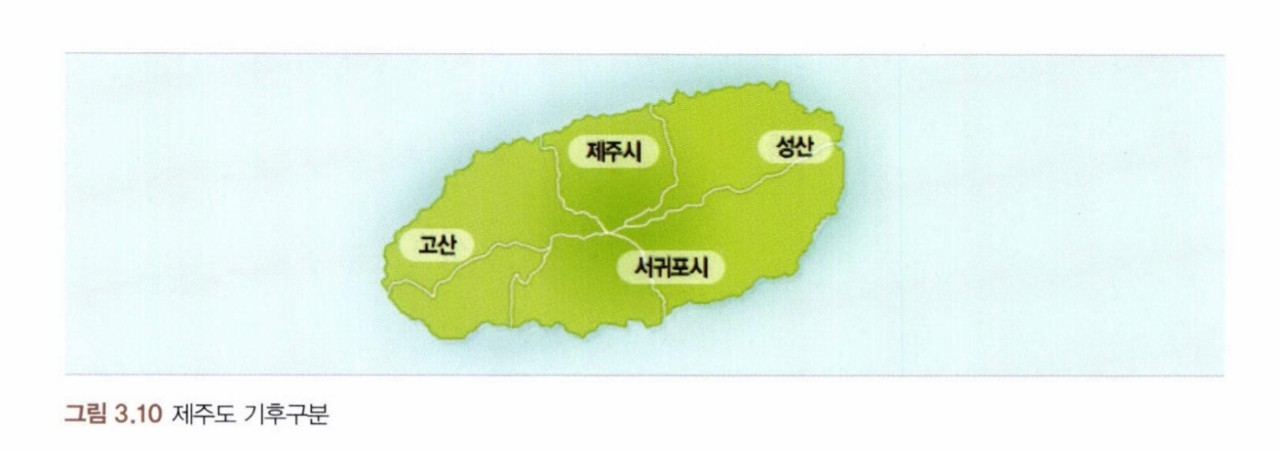
- 제주도의 기후는 크게 보아 4개의 지역에 따라 달라지며, 지역마다 기상 정보 측정소가 있음
- 따라서 날씨 관련 변수 생성에 앞서 각 버스 정류장별 가장 가까운 측정소에 대한 변수를 먼저 생성해야함

- **버스 정류장과 각 측정소의 거리(dis_jeju, dis_gosan, dis_seongsan, dis_po)**
- 버스 정류장이 어느 지역에 해당하는지 알기 위해서는 버스 정류장과 측정소 간 거리가 필요함
- 제주도에 존재하는 동서남북 각각 1개씩 총 4개의 측정소의 위치를 활용해 해당 지역과 버스 정류장의 거리를 각각 변수로 추가하겠음
- 다음은 버스 정류장의 위도, 경도와 4개 측정소의 위도, 경도를 통해 버스 정류장과 측정소 사이의 거리를 km 단위로 계산하는 코드임

In [55]:
# 측정소별 위도, 경도
jeju = (33.51411, 126.52969) # 제주 측정소 근처
gosan = (33.29382, 126.16283) # 고산 측정소 근처
seongsan = (33.38677, 126.8802) # 성산 측정소 근처
po = (33.24616, 126.5653) # 서귀포 측정소 근처

# 버스 정류장과 제주 측정소와의 거리
t1 = [geopy.distance.geodesic((i,j), jeju).km for i,j in list(zip(df['latitude'], df['longitude']))]
df['dis_jeju'] = t1

# 버스 정류장과 고산 측정소와의 거리
t2 = [geopy.distance.geodesic((i,j), gosan).km for i,j in list(zip(df['latitude'], df['longitude']))]
df['dis_gosan'] = t2

# 버스 정류장과 성산 측정소와의 거리
t3 = [geopy.distance.geodesic((i,j), seongsan).km for i,j in list(zip(df['latitude'], df['longitude']))]
df['dis_seongsan'] = t3

# 버스 정류장과 서귀포 측정소와의 거리
t4 = [geopy.distance.geodesic((i,j), po).km for i,j in list(zip(df['latitude'], df['longitude']))]
df['dis_po'] = t4

df[['dis_jeju','dis_gosan','dis_seongsan','dis_po']].head()


dis_jeju  dis_gosan  dis_seongsan     dis_po
0   4.286659  37.692766     37.713630  27.841879
1   4.966848  37.008492     38.465822  27.996179
2   6.330746  35.642126     39.259820  27.496551
3   3.575272  38.643401     38.386802  29.579404
4  30.652098  23.648361     45.899140  14.269792

- **버스 정류장과 가장 가까운 측정소(dist_name)**
- 앞서 4개의 측정소와 버스 정류장의 거리를 구해 새로운 변수를 생성했음
- 새로운 변수들을 활용하여 각 버스 정류장에서 가장 가까운 측정소를 구해 최종적으로 각 버스 정류장이 어느 지역의 측정소와 가장 가까운지에 대한 변수를 생성하겠음

In [56]:
total = pd.DataFrame(list(zip(t1, t2, t3, t4)),
                    columns=['jeju','gosan','seongsan','po'])
df['dist_name'] = total.apply(lambda x: x.idxmin(), axis=1)

In [57]:
df[['dist_name']].head()

dist_name
0      jeju
1      jeju
2      jeju
3      jeju
4        po

- **지점별 기상정보 변수(temperature, rainfall)**
- 좌표를 활용한 변수에서 생성한 지점 변수와 기상청에서 제공하는 기상정보 측정 데이터를 사용해 지점별 기상정보를 변수로 생성하겠음
- 기상정보 측정 데이터는 기상자료개방포털(https://data.kma.go.kr/cmmm/main.do)에서 제주도 전체를 선택한 후 사용하려는 일자, 기온, 강수량을 선택한 뒤 내려받을 수 있음
- 내려받은 데이터는 rain.csv로 저장함
- 외부 데이터 시아요 기간은 2019.9.1 ~ 10.16이며 해당 데이터를 불러온 뒤 오전 6~11시에 해당하는 정보만 편집해서 사용했으므로 데이터 누수가 아님
- rain 데이터의 변수명은 '데이터 설명'에서 확인했듯이 한글로 지정되어 있음
- 한글이 포함된 변수가 존재하면 모델 학습 시 오류가 날 수 있으므로 적절한 변수명으로 변경해줌
- 또 rainfall 변수에 존재하는 결측치는 비가 오지 않은 상황에 해당하므로 결측치를 0으로 대체

In [58]:
# 변수명 변경
# ['지점','일시','기온(*C)','강수량(mm)']

rain.columns = ['dist_name','date','temperature','rainfall']

# fillna 함수를 활용해 결측치를 0으로 치환
rain = rain.fillna(0)

# rain 데이터의 date 변수를 datetime 형태로 변환
rain['date'] = pd.to_datetime(rain['date'])
# 기존의 데이터프레임에 새로운 변수를 병합
df = pd.merge(df, rain, how='left', on=['dist_name','date'])

- 위 코드를 실행한 결과 숫자형인 temperature, rainfall 변수를 생성하겠음
- 일별 기온과 강수량을 나타내는 값이 들어간 것을 확인할 수 있음

In [59]:
df[['temperature', 'rainfall']].head()

temperature  rainfall
0    24.650000       0.0
1    24.650000       0.0
2    24.650000       0.0
3    24.650000       0.0
4    23.783333       0.0

- **비의 유무를 나타내는 변수(rainy_day)**
- '기상 조건에 따른 대중교통 수요변화에 관한 연구'에서 기상 조건에 따른 이동수단 변경 이유 중 70% 이상이 비에 의해 발생하는 문제로 인해 이동수단을 변경한다는 결과가 나왔음
- 이를 통해 다른 기상 조건보다 비의 유무가 탑승객 수에 더 큰 영향을 줄 수 있다는 것을 알 수 있음
- 따라서 비의 유무를 나타내는 rainy_day 변수를 생성함

In [60]:
def is_rainy(x):
    if x == 0:
        return 0 # 비 안오는 날
    else:
        return 1 # 비 오는 날
    
df['rainy_day'] = df['rainfall'].apply(is_rainy)

In [61]:
df[['rainy_day']].head()

rainy_day
0          0
1          0
2          0
3          0
4          0

- **jeju_financial_life_data를 활용한 변수**
- 외부 데이터인 jeju_financial_life_data를 활용하려면 기존 데이터인 df와 병합해야 함
- 두 데이터를 병합하려면 기준이 되는 공통 변수가 하나 이상 있어야 함
- jeju_financial_life_data 데이터와 df 데이터에는 각각 위도와 경도를 나타내는 변수가 존재함
- jeju_financial_life_data의 위도 변수는 y_axis, 경도 변수는 x_axis이고, df의 위도 변수는 latitude, 경도 변수는 longitude임
- 형태가 서로 달라 공통된 키(key)가 될 수 없음
---
- 두 데이터를 병합할 수 있는 또 다른 키로 행정 구역 이름을 사용할 수 있음
- 두 데이터 모두 기존 변수에 행정 구역 이름 변수가 없지만, 위도 경도 변수를 통해 행정 구역 이름을 추출할 수 있음
- 따라서 위도 경도가 있는 데이터를 넣으면 행정 구역 이름이라는 변수를 추가한 데이터를 반환해주는 Geocoder-Xr 프로그램을 사용해 jeju_financial_life_data와 df의 행정 구역 이름을 추출함
- Geocoder-Xr 프로그램의 이용법은 jeju_life_location.ipynb 파일에서 확인할 수 있음

In [65]:
# df 주소 데이터(df_location.csv) 로드
df_loc= pd.read_csv('df_location.csv', encoding='cp949')[['location','dong','si']]
# jeju_life 주소 데이터(life_location.csv) 로드
life_loc = pd.read_csv('life_location.csv', encoding='cp949')[['location','dong','si']]

# df의 위도, 경도 변수를 문자열로 취급하여 location 변수 생성
df['location'] = df['latitude'].astype(str) + ',' + df['longitude'].astype(str)
# jeju_life의 위도, 경두 변수를 문자열로 취급하여 location 변수 생성
jeju_life['location'] = jeju_life['y_axis'].astype(str).str[:10] + ',' + jeju_life['x_axis'].astype(str).str[:10]

# location 변수를 기준으로 df와 df_loc 병합
df = pd.merge(df, df_loc, how='left', on='location')
# location 변수를 기준으로 jeju_life와 life_loc 병합
jeju_life = pd.merge(jeju_life, life_loc, how='left', on='location')

In [66]:
df[['location','dong','si']].head()

location  dong    si
0            33.4899,126.49373    연동   제주시
1           33.48944,126.48508    연동   제주시
2           33.48181,126.47352   노형동   제주시
3           33.50577,126.49252  용담이동   제주시
4  33.255790000000005,126.4126   색달동  서귀포시

- **각 동(읍, 면별) 직업, 소득, 소비, 부동산 관련 변수의 평균, 합계, 비율**
- 병합을 통해 생성된 데이터를 사용해 새로운 변수를 만들어 보겠음
- jeju_financial_life_data에서 필요한 직업 관련 변수(job_majorc, job_smallc, job_public, job_profession, job_self)
- 소득 관련 변수(avg_income, med_income)
- 소비 관련 변수(avg_spend)
- 부동산 관련 변수(vehicle_own_rat)를 col에 저장함
---
- 예측해야 할 퇴근시간 승차인원은 해당 지역의 인구통계학적인 정보와 관련이 있을 수 있음
- 예를 들면 jeju_financial_life_data에서 job_public은 공무원 종사자의 비율
    - job_self는 자영업 종사자의 비율을 의미함
- 해당 지역에 공무원 종사자의 비율이 자영업 종사자의 비율보다 높다면 출퇴근 시간의 이동패턴이 일정할 것이라고 예상할 수 있음
- 따라서 groupby() 명령어를 통해 jeju_financial_life_data의 동(읍,면)을 기준으로 job_majorc, job_smallc, job_public, job_profession, job_self, vehicle_own_rat, avg_income, med_income, avg_spend 변수들의 평균, 합계, 비율을 구함
- 이제 생성한 변수를 기존 데이터인 df와 병합함
- 기준이 되는 키는 지오코딩 프로그램을 통해 얻은 주소를 전처리해 만든 dong 변수임

In [68]:
col = ['job_majorc', 'job_smallc', 'job_public', 'job_profession', 'job_self', 'avg_income', 'med_income',
      'avg_spend', 'vehicle_own_rat']

# groupby 함수를 사용해 dong을 기준으로 위에서 선택한 변수들의 평균을 구함
data1 = jeju_life.groupby(['dong'])[col].mean().reset_index()
data1.columns = ['dong','mean_job_majorc', 'mean_job_smallc', 'mean_job_public', 'mean_job_profession', 'mean_job_self', 
                 'mean_vehicle_own_rat', 'mean_avg_income','mean_med_income','mean_avg_spend']

# groupby 함수를 사용해 dong을 기준으로 위에서 서낵한 변수들의 합계를 구함
data2 = jeju_life.groupby(['dong'])[col].sum().reset_index()
data2.columns = ['dong','sum_job_majorc', 'sum_job_smallc', 'sum_job_public', 'sum_job_profession', 'sum_job_self', 
                 'sum_vehicle_own_rat', 'sum_avg_income','sum_med_income','sum_avg_spend']

# groupby 함수를 사용해 dong을 기준으로 위에서 서낵한 변수들의 합계를 구함
data3 = (jeju_life.groupby(['dong'])[col].sum() \
             / jeju_life.groupby(['dong'])[col].sum().sum()).reset_index()
data3.columns = ['dong','rate_job_majorc', 'rate_job_smallc', 'rate_job_public', 'rate_job_profession', 'rate_job_self', 
                 'rate_vehicle_own_rat', 'rate_avg_income','rate_med_income','rate_avg_spend']

# dong을 기준으로 기존의 데이터프레임에 새로운 변수를 병합
merge_data1 = pd.merge(data1, data2, how='left', on='dong')
merge_data2 = pd.merge(merge_data1, data3, how='left', on='dong')
df = pd.merge(df, merge_data2, how='left', on='dong')

In [69]:
df

id       date bus_route_id in_out  station_code   station_name  \
0            0 2019-09-01      4270000     시외           344          제주썬호텔   
1            1 2019-09-01      4270000     시외           357           한라병원   
2            2 2019-09-01      4270000     시외           432           정존마을   
3            3 2019-09-01      4270000     시내          1579   제주국제공항(600번)   
4            4 2019-09-01      4270000     시내          1646       중문관광단지입구   
...        ...        ...          ...    ...           ...            ...   
643588  643588 2019-10-16     32820000     시내           786  고산환승정류장(고산1리)   
643589  643589 2019-10-16     32820000     시내          1080         애월고등학교   
643590  643590 2019-10-16     32820000     시내          1129   한림환승정류장(한림리)   
643591  643591 2019-10-16     32820000     시내          1564      제주시외버스터미널   
643592  643592 2019-10-16     32820000     시내       6115100     서귀포시외버스터미널   

        latitude  longitude  6~7_ride  7~8_ride  ...  sum_avg_spend  \
0       33.48990  126.49373       0.0       1.0  ...      19.570112   
1       33.48944  126.48508       1.0       4.0  ...      19.570112   
2       33.48181  126.47352       1.0       1.0  ...      21.583853   
3       33.50577  126.49252       0.0      17.0  ...       7.267512   
4       33.25579  126.41260       0.0       0.0  ...       1.298941   
...          ...        ...       ...       ...  ...            ...   
643588  33.30073  126.18044       0.0       0.0  ...       6.381036   
643589  33.46262  126.33447       0.0       0.0  ...      30.562739   
643590  33.41437  126.26336       3.0       0.0  ...      23.386927   
643591  33.49946  126.51479       3.0       0.0  ...       3.208592   
643592  33.24873  126.50799       0.0       0.0  ...       4.128322   

        rate_job_majorc  rate_job_smallc  rate_job_public  \
0              0.070785         0.067234         0.072519   
1              0.070785         0.067234         0.072519   
2              0.074411         0.063195         0.077104   
3              0.023328         0.027259         0.025523   
4              0.003858         0.003461         0.001627   
...                 ...              ...              ...   
643588         0.018419         0.013462         0.010103   
643589         0.056423         0.059691         0.049915   
643590         0.048730         0.042162         0.025943   
643591         0.007036         0.009240         0.008456   
643592         0.007589         0.009322         0.012484   

        rate_job_profession  rate_job_self  rate_vehicle_own_rat  \
0                  0.059186       0.039145              0.060589   
1                  0.059186       0.039145              0.060589   
2                  0.081449       0.038947              0.062667   
3                  0.022257       0.015078              0.020857   
4                  0.000816       0.004044              0.002819   
...                     ...            ...                   ...   
643588             0.012421       0.025668              0.020548   
643589             0.052445       0.071244              0.059991   
643590             0.032844       0.062580              0.051705   
643591             0.006682       0.005804              0.006765   
643592             0.006420       0.011198              0.009166   

        rate_avg_income  rate_med_income  rate_avg_spend  
0              0.059915         0.065706        0.048458  
1              0.059915         0.065706        0.048458  
2              0.062396         0.071018        0.053445  
3              0.021994         0.022053        0.017995  
4              0.002728         0.002696        0.003216  
...                 ...              ...             ...  
643588         0.019357         0.016488        0.015800  
643589         0.060850         0.060186        0.075678  
643590         0.048383         0.041100        0.057909  
643591         0.007094         0.007818        0.007945  
643592         0.009079

- df에는 있지만 jeju_life에는 없는 동이 존재함
- 따라서 데이터 병합을 거치면 위의 과정에서 생성한 27개의 변수에 각각 201개의 결측치가 생긴 것을 확인할 수 있음

In [70]:
# 새로 생성한 27개의 변수 정보
df[merge_data2.columns[1:]].info() # 새로 생성한 27개 변수 각각 201개의 결측치가 존재

<class 'pandas.core.frame.DataFrame'>
Int64Index: 643593 entries, 0 to 643592
Data columns (total 27 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   mean_job_majorc       641868 non-null  float64
 1   mean_job_smallc       641868 non-null  float64
 2   mean_job_public       641868 non-null  float64
 3   mean_job_profession   641868 non-null  float64
 4   mean_job_self         641868 non-null  float64
 5   mean_vehicle_own_rat  641868 non-null  float64
 6   mean_avg_income       641868 non-null  float64
 7   mean_med_income       641868 non-null  float64
 8   mean_avg_spend        641868 non-null  float64
 9   sum_job_majorc        641868 non-null  float64
 10  sum_job_smallc        641868 non-null  float64
 11  sum_job_public        641868 non-null  float64
 12  sum_job_profession    641868 non-null  float64
 13  sum_job_self          641868 non-null  float64
 14  sum_vehicle_own_rat   641868 non-null  float64
 15  

In [71]:
# 평균값으로 결측치 대체
# 결측치를 각 변수의 평균값으로 처리할 수 있도록 SimpleImputer를 사용
imputer = SimpleImputer(strategy='mean')

# 결측치가 존재하는 변수 목록
na_col = list(merge_data2.columns[1:])

# 각 변수에 대해 평균값을 구하고 결측치 대치를 위해 fit_transform을 사용
df[na_col] = pd.DataFrame(imputer.fit_transform(df[na_col]), columns=na_col)

In [72]:
# 결측치 확인
df[na_col].isnull().sum()

mean_job_majorc         0
mean_job_smallc         0
mean_job_public         0
mean_job_profession     0
mean_job_self           0
mean_vehicle_own_rat    0
mean_avg_income         0
mean_med_income         0
mean_avg_spend          0
sum_job_majorc          0
sum_job_smallc          0
sum_job_public          0
sum_job_profession      0
sum_job_self            0
sum_vehicle_own_rat     0
sum_avg_income          0
sum_med_income          0
sum_avg_spend           0
rate_job_majorc         0
rate_job_smallc         0
rate_job_public         0
rate_job_profession     0
rate_job_self           0
rate_vehicle_own_rat    0
rate_avg_income         0
rate_med_income         0
rate_avg_spend          0
dtype: int64

## 라벨 인코딩과 원핫 인코딩 변수

- 머신러닝에 입력으로 들어가는 변수는 반드시 숫자형 변수여야 함
- 문자형 변수를 숫자형 변수로 변환함
- 이번 절에서는 앞서 생성한 문자형 변수를 라벨 인코딩과 원핫 인코딩 방법을 통해 숫자형 변수로 변환하는 방법을 소개하겠음

- **라벨 인코딩 변수**
- 라벨 인코딩은 문자열로 된 변수의 값들을 등장하는 순서대로 넘버링해서 숫자형으로 변환하는 방법임
- 라벨 인코딩을 사용해 내부 데이터와 외부 데이터를 통해 생성한 문자형 변수를 숫자형 변수로 변환하겠음
---
- **시내 시외(in_out)**
- 시내버스와 시외버스를 구분하는 변수가 문자형이므로 숫자형으로 변환함

In [73]:
df['in_out'] = df['in_out'].map({'시내':0,'시외':1})
df

id       date bus_route_id  in_out  station_code   station_name  \
0            0 2019-09-01      4270000       1           344          제주썬호텔   
1            1 2019-09-01      4270000       1           357           한라병원   
2            2 2019-09-01      4270000       1           432           정존마을   
3            3 2019-09-01      4270000       0          1579   제주국제공항(600번)   
4            4 2019-09-01      4270000       0          1646       중문관광단지입구   
...        ...        ...          ...     ...           ...            ...   
643588  643588 2019-10-16     32820000       0           786  고산환승정류장(고산1리)   
643589  643589 2019-10-16     32820000       0          1080         애월고등학교   
643590  643590 2019-10-16     32820000       0          1129   한림환승정류장(한림리)   
643591  643591 2019-10-16     32820000       0          1564      제주시외버스터미널   
643592  643592 2019-10-16     32820000       0       6115100     서귀포시외버스터미널   

        latitude  longitude  6~7_ride  7~8_ride  ...  sum_avg_spend  \
0       33.48990  126.49373       0.0       1.0  ...      19.570112   
1       33.48944  126.48508       1.0       4.0  ...      19.570112   
2       33.48181  126.47352       1.0       1.0  ...      21.583853   
3       33.50577  126.49252       0.0      17.0  ...       7.267512   
4       33.25579  126.41260       0.0       0.0  ...       1.298941   
...          ...        ...       ...       ...  ...            ...   
643588  33.30073  126.18044       0.0       0.0  ...       6.381036   
643589  33.46262  126.33447       0.0       0.0  ...      30.562739   
643590  33.41437  126.26336       3.0       0.0  ...      23.386927   
643591  33.49946  126.51479       3.0       0.0  ...       3.208592   
643592  33.24873  126.50799       0.0       0.0  ...       4.128322   

        rate_job_majorc  rate_job_smallc  rate_job_public  \
0              0.070785         0.067234         0.072519   
1              0.070785         0.067234         0.072519   
2              0.074411         0.063195         0.077104   
3              0.023328         0.027259         0.025523   
4              0.003858         0.003461         0.001627   
...                 ...              ...              ...   
643588         0.018419         0.013462         0.010103   
643589         0.056423         0.059691         0.049915   
643590         0.048730         0.042162         0.025943   
643591         0.007036         0.009240         0.008456   
643592         0.007589         0.009322         0.012484   

        rate_job_profession  rate_job_self  rate_vehicle_own_rat  \
0                  0.059186       0.039145              0.060589   
1                  0.059186       0.039145              0.060589   
2                  0.081449       0.038947              0.062667   
3                  0.022257       0.015078              0.020857   
4                  0.000816       0.004044              0.002819   
...                     ...            ...                   ...   
643588             0.012421       0.025668              0.020548   
643589             0.052445       0.071244              0.059991   
643590             0.032844       0.062580              0.051705   
643591             0.006682       0.005804              0.006765   
643592             0.006420       0.011198              0.009166   

        rate_avg_income  rate_med_income  rate_avg_spend  
0              0.059915         0.065706        0.048458  
1              0.059915         0.065706        0.048458  
2              0.062396         0.071018        0.053445  
3              0.021994         0.022053        0.017995  
4              0.002728         0.002696        0.003216  
...                 ...              ...             ...  
643588         0.019357         0.016488        0.015800  
643589         0.060850         0.060186        0.075678  
643590         0.048383         0.041100        0.057909  
643591         0.007094         0.007818        0.007945  
643592     

- **주중 및 주말**
- 주말에는 회사에 출근을 하지 않으므로 주중과는 또 다른 버스 승하차 형태가 존재함
- 이러한 특성을 반영하기 위해 주말과 주중을 구분할 수 있는 변수를 생성함

In [74]:
def is_weekend(x):
    if x == 5: # 토요일
        return 1
    elif x == 6: # 일요일
        return 1
    else:
        return 0
    

# weekday 변수에 is_weekend() 함수를 적용하여 weekend 변수 생성
df['weekend'] = df['weekday'].apply(is_weekend)
df

id       date bus_route_id  in_out  station_code   station_name  \
0            0 2019-09-01      4270000       1           344          제주썬호텔   
1            1 2019-09-01      4270000       1           357           한라병원   
2            2 2019-09-01      4270000       1           432           정존마을   
3            3 2019-09-01      4270000       0          1579   제주국제공항(600번)   
4            4 2019-09-01      4270000       0          1646       중문관광단지입구   
...        ...        ...          ...     ...           ...            ...   
643588  643588 2019-10-16     32820000       0           786  고산환승정류장(고산1리)   
643589  643589 2019-10-16     32820000       0          1080         애월고등학교   
643590  643590 2019-10-16     32820000       0          1129   한림환승정류장(한림리)   
643591  643591 2019-10-16     32820000       0          1564      제주시외버스터미널   
643592  643592 2019-10-16     32820000       0       6115100     서귀포시외버스터미널   

        latitude  longitude  6~7_ride  7~8_ride  ...  rate_job_majorc  \
0       33.48990  126.49373       0.0       1.0  ...         0.070785   
1       33.48944  126.48508       1.0       4.0  ...         0.070785   
2       33.48181  126.47352       1.0       1.0  ...         0.074411   
3       33.50577  126.49252       0.0      17.0  ...         0.023328   
4       33.25579  126.41260       0.0       0.0  ...         0.003858   
...          ...        ...       ...       ...  ...              ...   
643588  33.30073  126.18044       0.0       0.0  ...         0.018419   
643589  33.46262  126.33447       0.0       0.0  ...         0.056423   
643590  33.41437  126.26336       3.0       0.0  ...         0.048730   
643591  33.49946  126.51479       3.0       0.0  ...         0.007036   
643592  33.24873  126.50799       0.0       0.0  ...         0.007589   

        rate_job_smallc  rate_job_public  rate_job_profession  rate_job_self  \
0              0.067234         0.072519             0.059186       0.039145   
1              0.067234         0.072519             0.059186       0.039145   
2              0.063195         0.077104             0.081449       0.038947   
3              0.027259         0.025523             0.022257       0.015078   
4              0.003461         0.001627             0.000816       0.004044   
...                 ...              ...                  ...            ...   
643588         0.013462         0.010103             0.012421       0.025668   
643589         0.059691         0.049915             0.052445       0.071244   
643590         0.042162         0.025943             0.032844       0.062580   
643591         0.009240         0.008456             0.006682       0.005804   
643592         0.009322         0.012484             0.006420       0.011198   

        rate_vehicle_own_rat  rate_avg_income  rate_med_income  \
0                   0.060589         0.059915         0.065706   
1                   0.060589         0.059915         0.065706   
2                   0.062667         0.062396         0.071018   
3                   0.020857         0.021994         0.022053   
4                   0.002819         0.002728         0.002696   
...                      ...              ...              ...   
643588              0.020548         0.019357         0.016488   
643589              0.059991         0.060850         0.060186   
643590              0.051705         0.048383         0.041100   
643591              0.006765         0.007094         0.007818   
643592              0.009166         0.009079         0.008528   

        rate_avg_spend  weekend  
0             0.048458        1  
1             0.048458        1  
2             0.053445        1  
3             0.017995        1  
4             0.003216        1  
...                ...      ...  
643588        0.015800        0  
643589        0.075678        0  
643590        0.057909        0  
643591        0.007945        0  
643592        0.010222        0  

[643593 rows x 104 colu

- **시, 동**
- jeju_financial_life_data를 활용한 변수에서 지오코딩 프로그램을 통해 생성한 si변수는 버스 정류장이 제주시와 서귀포시 중 어느 곳에 속하는지를 나타냄
- 또한 dong 변수도 마찬가지로 어느 동에 속하는지 나타냄
- 따라서 si 변수와 dong 변수를 라벨 인코딩하여 지역 정보와 관련된 변수를 추가함

In [75]:
# sklearn 라이브러리에서 라벨 인코딩 객체 불러와서 저장하기
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()

# 라벨 인코딩 할 변수 선택
df_encode = df[['si','dong']]

# it_transform을 통해 라벨 인코딩
df_encoded = df_encode.apply(labelencoder.fit_transform)
df['si'] = df_encoded['si']
df['dong'] = df_encoded['dong']
df[['si','dong']].head()

si  dong
0   1    36
1   1    36
2   1     5
3   1    47
4   0    26

- **원핫 인코딩 변수**
- 원핫 인코딩은 어떤 특징이 존재하면 0, 존재하지 않으면 1의 값을 가지게 표시하는 방법임
- 범주형 변수를 수치형 변수로 변환할 수 있음
- 해당 변수의 범주 값이 n개이면 n개의 더미 변수가 생성됨
- 원핫 인코딩을 사용하여 내부와 외부 데이터를 통해 생성된 문자 범주 변수를 숫자형 변수로 변환함
---
- **weekday, dist_name**
- 탐색적 데이터 분석을 통한 변수에서 생성한 weekday 변수와 좌표를 활용한 변수에서 생성한 dist_name 변수를 원핫 인코딩해 문자형 변수를 숫자형 변수로 변환함

In [76]:
df

id       date bus_route_id  in_out  station_code   station_name  \
0            0 2019-09-01      4270000       1           344          제주썬호텔   
1            1 2019-09-01      4270000       1           357           한라병원   
2            2 2019-09-01      4270000       1           432           정존마을   
3            3 2019-09-01      4270000       0          1579   제주국제공항(600번)   
4            4 2019-09-01      4270000       0          1646       중문관광단지입구   
...        ...        ...          ...     ...           ...            ...   
643588  643588 2019-10-16     32820000       0           786  고산환승정류장(고산1리)   
643589  643589 2019-10-16     32820000       0          1080         애월고등학교   
643590  643590 2019-10-16     32820000       0          1129   한림환승정류장(한림리)   
643591  643591 2019-10-16     32820000       0          1564      제주시외버스터미널   
643592  643592 2019-10-16     32820000       0       6115100     서귀포시외버스터미널   

        latitude  longitude  6~7_ride  7~8_ride  ...  rate_job_majorc  \
0       33.48990  126.49373       0.0       1.0  ...         0.070785   
1       33.48944  126.48508       1.0       4.0  ...         0.070785   
2       33.48181  126.47352       1.0       1.0  ...         0.074411   
3       33.50577  126.49252       0.0      17.0  ...         0.023328   
4       33.25579  126.41260       0.0       0.0  ...         0.003858   
...          ...        ...       ...       ...  ...              ...   
643588  33.30073  126.18044       0.0       0.0  ...         0.018419   
643589  33.46262  126.33447       0.0       0.0  ...         0.056423   
643590  33.41437  126.26336       3.0       0.0  ...         0.048730   
643591  33.49946  126.51479       3.0       0.0  ...         0.007036   
643592  33.24873  126.50799       0.0       0.0  ...         0.007589   

        rate_job_smallc  rate_job_public  rate_job_profession  rate_job_self  \
0              0.067234         0.072519             0.059186       0.039145   
1              0.067234         0.072519             0.059186       0.039145   
2              0.063195         0.077104             0.081449       0.038947   
3              0.027259         0.025523             0.022257       0.015078   
4              0.003461         0.001627             0.000816       0.004044   
...                 ...              ...                  ...            ...   
643588         0.013462         0.010103             0.012421       0.025668   
643589         0.059691         0.049915             0.052445       0.071244   
643590         0.042162         0.025943             0.032844       0.062580   
643591         0.009240         0.008456             0.006682       0.005804   
643592         0.009322         0.012484             0.006420       0.011198   

        rate_vehicle_own_rat  rate_avg_income  rate_med_income  \
0                   0.060589         0.059915         0.065706   
1                   0.060589         0.059915         0.065706   
2                   0.062667         0.062396         0.071018   
3                   0.020857         0.021994         0.022053   
4                   0.002819         0.002728         0.002696   
...                      ...              ...              ...   
643588              0.020548         0.019357         0.016488   
643589              0.059991         0.060850         0.060186   
643590              0.051705         0.048383         0.041100   
643591              0.006765         0.007094         0.007818   
643592              0.009166         0.009079         0.008528   

        rate_avg_spend  weekend  
0             0.048458        1  
1             0.048458        1  
2             0.053445        1  
3             0.017995        1  
4             0.003216        1  
...                ...      ...  
643588        0.015800        0  
643589        0.075678        0  
643590        0.057909        0  
643591        0.007945        0  
643592        0.010222        0  

[643593 rows x 104 colu

In [77]:
df = pd.get_dummies(df, columns=['weekday','dist_name'])
df

id       date bus_route_id  in_out  station_code   station_name  \
0            0 2019-09-01      4270000       1           344          제주썬호텔   
1            1 2019-09-01      4270000       1           357           한라병원   
2            2 2019-09-01      4270000       1           432           정존마을   
3            3 2019-09-01      4270000       0          1579   제주국제공항(600번)   
4            4 2019-09-01      4270000       0          1646       중문관광단지입구   
...        ...        ...          ...     ...           ...            ...   
643588  643588 2019-10-16     32820000       0           786  고산환승정류장(고산1리)   
643589  643589 2019-10-16     32820000       0          1080         애월고등학교   
643590  643590 2019-10-16     32820000       0          1129   한림환승정류장(한림리)   
643591  643591 2019-10-16     32820000       0          1564      제주시외버스터미널   
643592  643592 2019-10-16     32820000       0       6115100     서귀포시외버스터미널   

        latitude  longitude  6~7_ride  7~8_ride  ...  weekday_1  weekday_2  \
0       33.48990  126.49373       0.0       1.0  ...          0          0   
1       33.48944  126.48508       1.0       4.0  ...          0          0   
2       33.48181  126.47352       1.0       1.0  ...          0          0   
3       33.50577  126.49252       0.0      17.0  ...          0          0   
4       33.25579  126.41260       0.0       0.0  ...          0          0   
...          ...        ...       ...       ...  ...        ...        ...   
643588  33.30073  126.18044       0.0       0.0  ...          0          1   
643589  33.46262  126.33447       0.0       0.0  ...          0          1   
643590  33.41437  126.26336       3.0       0.0  ...          0          1   
643591  33.49946  126.51479       3.0       0.0  ...          0          1   
643592  33.24873  126.50799       0.0       0.0  ...          0          1   

        weekday_3  weekday_4  weekday_5  weekday_6  dist_name_gosan  \
0               0          0          0          1                0   
1               0          0          0          1                0   
2               0          0          0          1                0   
3               0          0          0          1                0   
4               0          0          0          1                0   
...           ...        ...        ...        ...              ...   
643588          0          0          0          0                1   
643589          0          0          0          0                0   
643590          0          0          0          0                1   
643591          0          0          0          0                0   
643592          0          0          0          0                0   

        dist_name_jeju  dist_name_po  dist_name_seongsan  
0                    1             0                   0  
1                    1             0                   0  
2                    1             0                   0  
3                    1             0                   0  
4                    0             1                   0  
...                ...           ...                 ...  
643588               0             0                   0  
643589               1             0                   0  
643590               0             0                   0  
643591               1             0                   0  
643592               0             1                   0  

[643593 rows x 113 columns]

## 전체 변수 정리

- 3.3절에서 만든 전체 변수를 표 3.8에 정리하였음
- 본 경진대회에서는 몇 가지 변수를 추가로 사용했음

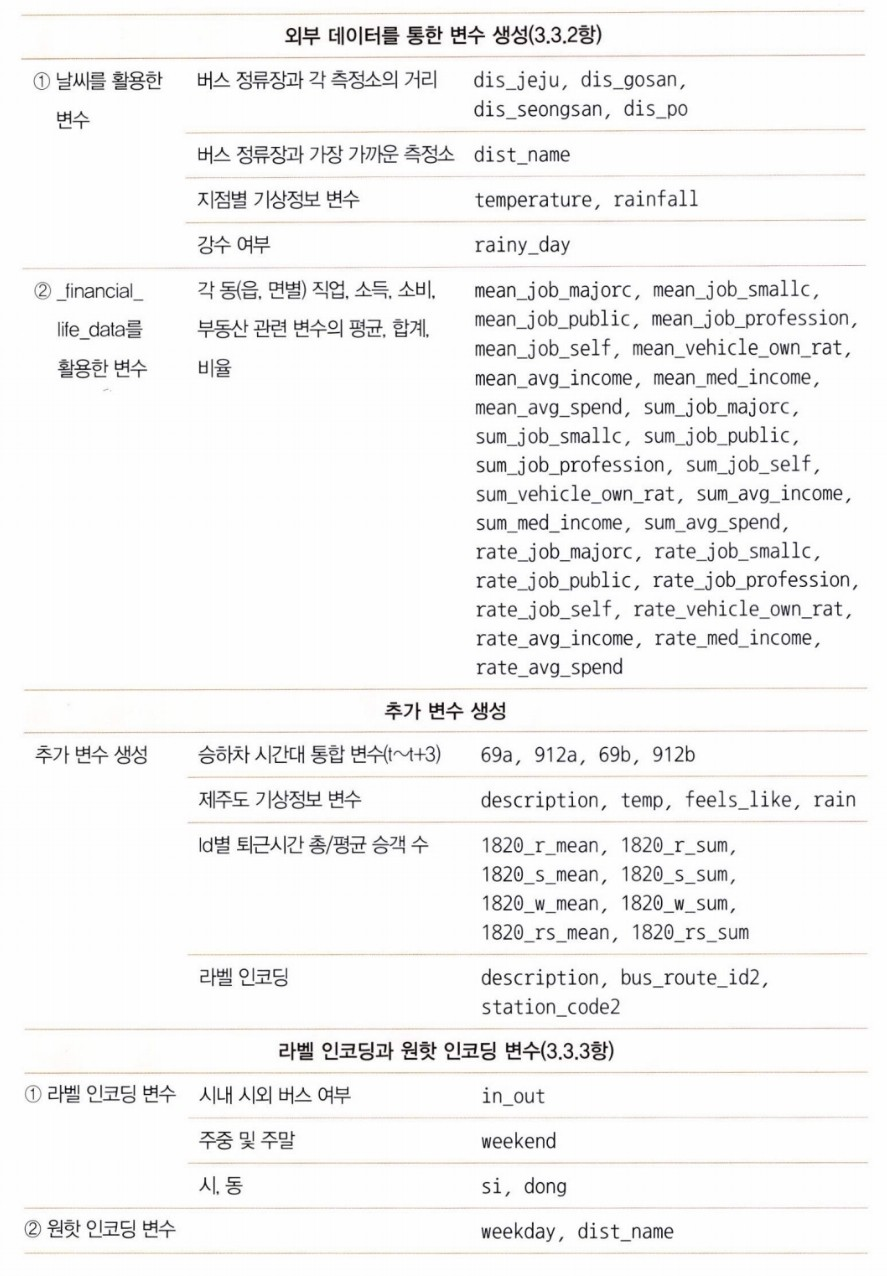